In [62]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import calendar
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from numpy import array
from math import sqrt
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
import keras.backend as K
import itertools
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from random import random
#!pip install pmdarima --quiet
import pmdarima as pm

# Code adapted from https://medium.com/data-science/time-series-forecasting-with-arima-sarima-and-sarimax-ee61099e78f6
# Plot data to view
def plot_data(df, feature):
    plt.figure(figsize=(15,7))
    plt.title(str(feature)+" by Month")
    plt.xlabel('Month')
    plt.ylabel(str(feature))
    plt.plot(df)
    plt.show()

#Determine rolling statistics to find trends
def rolling_statistics(df):
    df["rolling_avg"] = df[df.columns[0]].rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
    df["rolling_std"] = df[df.columns[0]].rolling(window=12).std()

    #Plot rolling statistics
    plt.figure(figsize=(15,7))
    plt.plot(df, color='#379BDB', label='Original')
    plt.plot(df["rolling_avg"], color='#D22A0D', label='Rolling Mean')
    plt.plot(df["rolling_std"], color='#142039', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

#Augmented Dickey-Fuller Test to test if the time series is stationary
#If ADF has p <= 0.05, data are stationary
def ADF(df):
    print('Results of Dickey Fuller Test for temperature:')
    dftest = adfuller(df, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value

    print(dfoutput)

    return dfoutput

def add_padding(y):

    # Create rows of padding with zeros
    if isinstance(y[0][0], float) or isinstance(y[0][0], int):
        n_vars = 1
    else:
        n_vars = len(y[0][0])

    if n_vars == 1:
        padding = 0 * n_vars
    else:
        padding = [0 * n_vars]

    data = []
    
    for p in range(len(y)):
        for q in range(len(y[0])):
            data.append(y[p][q])
        
        for r in range(12):
            data.append(padding)

    return data

#Standard ARIMA Model
def fit_ARIMA_model(y, y_val, n_seq):

    best_p = 1
    best_q = 1
    best_rmse = -1

    for p in range(13):
        for q in range(13):
            # Check rmse for each fold
            cv_errors = []
            cv_mae = []
            cv_mape = []
            cv_r2 = []
            for k in range(5):
                series = pd.Series(y[k])
                
                model = pm.auto_arima(add_padding(y[k]), start_p=p, start_q=q, test='adf', # use adftest to find optimal 'd' 
                          max_p=p, max_q=q, # maximum p and q
                          m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                          d=None,# let model determine 'd'
                          seasonal=False, # No Seasonality for standard ARIMA
                          trace=False, #logs 
                          error_action='warn', #shows errors ('ignore' silences these)
                          suppress_warnings=True,
                          stepwise=True
                         )
                
                model_fit = model.fit(add_padding(y_val[k]))
                print(model_fit.summary())

                #Make predictions
                predictions = model_fit.predict(start=len(y[k][-n_seq]), end=len(series)-1)

                # Get actual values to compare against predictions
                actual = []
                for i in range(len(y_val[0])):
                    x2 = y_val[0]
                    y2=x2[i]
                    a = 178-n_seq
                    z2 = []
                    for j in reversed(range(n_seq)):
                        z2.append(y2[178-j])
                    if n_seq == 1:
                        actual.append(z2[0])
                    else:
                        actual.append(z2)
                    
                #Calculate the Root Mean Square Error (RMSE)
                mse = mean_squared_error(actual, predictions)
                rmse = np.sqrt(mse)
                mae = mean_absolute_error(actual, predictions)
                mape = mean_absolute_percentage_error(actual, predictions)
                r2 = r2_score(actual, predictions)
                cv_errors.append(rmse)
                cv_mae.append(mae)
                cv_mape.append(mape)
                cv_r2.append(r2)

            print("RMSE values for ARIMA model p="+str(p)+", q="+str(q)+":")
            print(cv_errors)
            
            # Print evaluation results
            print("Average of RMSE fold values: "+str(np.mean(cv_errors)))
            print("Standard Deviation of RMSE fold values: "+str(np.std(cv_errors)))
            print(f"Mean Absolute Error: {np.mean(cv_mae)}")
            print(f"Mean Absolute Percentage Error: {np.mean(cv_mape)}")
            print(f"R2 Score: {np.mean(cv_r2)}")
            if best_rmse == -1 or np.mean(cv_errors) < best_rmse:
                best_rmse = np.mean(cv_errors)
            if np.mean(cv_errors) < best_rmse:
                best_p = p
                best_q = q

    print("Best model is p="+str(best_p)+", q="+str(best_q))
    print("with RMSE="+str(best_rmse))
    
    return model

# SARIMAX Model
def fit_SARIMAX_model(X, y, X_val, y_val, exog, n_seq):

    best_p = 1
    best_q = 1
    best_rmse = -1

    for p in range(13):
        for q in range(13):
            # Check rmse for each fold
            cv_errors = []
            cv_mae = []
            cv_mape = []
            cv_r2 = []
            for k in range(5):
                series = pd.Series(y[k])
    
                model = pm.auto_arima(add_padding(y[k]), start_p=p, start_q=q, exogenous=exog,
                         test='adf', # use adftest to find optimal 'd'
                         max_p=p, max_q=q, m=12, #12 is the frequency of the cycle
                         start_P=0, seasonal=True,
                         d=None, D=1, 
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

                model_fit = model.fit(add_padding(y_val[k]))
                print(model_fit.summary())

                # Taken from https://medium.com/pythons-gurus/multi-step-forecasting-with-arima-predicting-long-term-climate-trends-291e5e08c2a2
                # Number of steps to forecast
                forecast_steps = n_seq

                # Perform multi-step forecasting
                forecast = model_fit.get_forecast(steps=forecast_steps)
                forecast_values = forecast.predicted_mean
                confidence_intervals = forecast.conf_int()

                # Plot the results
                plt.figure(figsize=(14, 7))
                plt.plot(data.index, data['Temperature'], label='Observed Temperature')
                forecast_index = pd.date_range(start=data.index[-1], periods=forecast_steps + 1, freq='M')[1:]
                plt.plot(forecast_index, forecast_values, label='Forecasted Temperature', linestyle='--')
                plt.fill_between(forecast_index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
                plt.title('Multi-step Temperature Forecast')
                plt.xlabel('Month')
                plt.ylabel('Temperature')
                plt.legend()
                plt.show()

                #Make predictions
                predictions = model_fit.predict(start=len(y[k][-n_seq]), end=len(series)-1)

                # Get actual values to compare against predictions
                actual = []
                for i in range(len(y_val[0])):
                    x2 = y_val[0]
                    y2=x2[i]
                    a = 178-n_seq
                    z2 = []
                    for j in reversed(range(n_seq)):
                        z2.append(y2[178-j])
                    if n_seq == 1:
                        actual.append(z2[0])
                    else:
                        actual.append(z2)
                    
                #Calculate the Root Mean Square Error (RMSE)
                mse = mean_squared_error(actual, predictions)
                rmse = np.sqrt(mse)
                mae = mean_absolute_error(actual, predictions)
                mape = mean_absolute_percentage_error(actual, predictions)
                r2 = r2_score(actual, predictions)
                cv_errors.append(rmse)
                cv_mae.append(mae)
                cv_mape.append(mape)
                cv_r2.append(r2)

            print("RMSE values for SARIMAX model p="+str(p)+", q="+str(q)+":")
            print(cv_errors)
            
            # Print evaluation results
            print("Average of RMSE fold values: "+str(np.mean(cv_errors)))
            print("Standard Deviation of RMSE fold values: "+str(np.std(cv_errors)))
            print(f"Mean Absolute Error: {np.mean(cv_mae)}")
            print(f"Mean Absolute Percentage Error: {np.mean(cv_mape)}")
            print(f"R2 Score: {np.mean(cv_r2)}")
            if best_rmse == -1 or np.mean(cv_errors) < best_rmse:
                best_rmse = np.mean(cv_errors)
            if np.mean(cv_errors) < best_rmse:
                best_p = p
                best_q = q

    print("Best model is p="+str(best_p)+", q="+str(best_q))
    print("with RMSE="+str(best_rmse))
        
    return model

def plot_diagnostics(model):
    model.plot_diagnostics(figsize=(15,12))
    plt.show
    
def ARIMA_forecast(ARIMA_model, df, periods=12):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df, color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("ARIMA Forecast")
    plt.show()

    return fitted_series, lower_series, upper_series

def SARIMAX_forecast(SARIMAX_model, df, exog, periods=12):
    # Forecast
    n_periods = periods

    forecast_df = pd.DataFrame({"month":pd.date_range(df.index[-1], periods = n_periods, freq='MS').month},
                    index = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS'))

    fitted, confint = SARIMAX_model.predict(n_periods=n_periods, 
                                            return_conf_int=True,
                                            exogenous=exog)
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df, color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("SARIMAX Forecast")
    plt.show()

    return fitted_series, lower_series, upper_series

# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))

# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# transform series into training sets
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(84):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)
    
    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (temperatures) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(84):
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        scaled_values_batch = scaled_values[first:last]
        train.append([scaled_values_batch])
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(21):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    # Transform each weather station as a separate "batch"
    for ws in range(21):
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        scaled_values_batch = scaled_values[first:last]
        # training/test/validation split is 80%/10%/10%
        if ws < 11:
            test.append([scaled_values_batch])
        else:
            validation.append([scaled_values_batch])
    
    return validation, test

def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))

def transform_data(data, n_lag, n_seq):
    
    X_row = []
    y_row = []
    temp_row = []
    sh_row = []
    PC1_row = []
    PC2_row = []
    PC3_row = []
    for j in range(len(data)):
        X2 = data[j]
        y2 = pd.DataFrame(X2[n_seq:n_lag+n_seq])
        X_row.append(pd.DataFrame(X2[:n_lag]))
        temp_row.append(X_row[j][X_row[j].columns[0]])
        sh_row.append(X_row[j][X_row[j].columns[1]])
        PC1_row.append(X_row[j][X_row[j].columns[2]])
        PC2_row.append(X_row[j][X_row[j].columns[3]])
        PC3_row.append(X_row[j][X_row[j].columns[4]])
        y_row.append(y2[y2.columns[0]])

    return X_row, y_row, temp_row, sh_row, PC1_row, PC2_row, PC3_row

#Main

#Configure
n_seq = 1
if n_seq > 46:
    n_lag = 179 - n_seq + 46
else:
    n_lag = 179
n_time_steps = 227
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])

#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([1, 2, 3, 5, 6, 7, 8, 9, 11, 13, 14, 15, 16, 17, 19, 20, 21, 22, 
                        23, 24, 25, 27, 28, 29, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 
                        43, 44, 46, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 
                        62, 63, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 81, 
                        82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 95, 97, 98, 100, 101, 102, 103])
test_array.append([0, 4, 10, 12, 18, 26, 30, 31, 33, 45, 47, 53, 64, 65, 77, 80, 89, 94, 96, 99, 104])
    
train_array.append([0, 1, 2, 3, 4, 6, 7, 8, 10, 12, 13, 14, 17, 18, 19, 20, 21, 23, 
                        24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 36, 37, 38, 41, 43, 45, 
                        46, 47, 48, 49, 50, 51, 52, 53, 54, 57, 58, 59, 60, 61, 63, 64, 
                        65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 77, 80, 81, 82, 83, 84, 
                        86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 104])
test_array.append([5, 9, 11, 15, 16, 22, 28, 35, 39, 40, 42, 44, 55, 56, 62, 72, 76, 78, 79, 85, 103])
    
train_array.append([0, 1, 2, 4, 5, 9, 10, 11, 12, 14, 15, 16, 18, 20, 21, 22, 23, 26, 
                    28, 29, 30, 31, 32, 33, 35, 36, 37, 39, 40, 41, 42, 44, 45, 46, 47, 
                    48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 
                    70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 82, 83, 85, 86, 87, 88, 89, 
                    90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104])
test_array.append([3, 6, 7, 8, 13, 17, 19, 24, 25, 27, 34, 38, 43, 49, 66, 67, 68, 69, 73, 81, 84])

train_array.append([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 
                        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 
                        35, 37, 38, 39, 40, 42, 43, 44, 45, 47, 49, 51, 52, 53, 55, 56, 
                        60, 62, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 76, 77, 78, 79, 
                        80, 81, 82, 84, 85, 86, 87, 88, 89, 92, 93, 94, 95, 96, 99, 102, 103, 104])
test_array.append([32, 36, 41, 46, 48, 50, 54, 57, 58, 59, 61, 63, 70, 75, 83, 90, 91, 97, 98, 100, 101])
    
train_array.append([0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 22,
                        24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 
                        42, 43, 44, 45, 46, 47, 48, 49, 50, 53, 54, 55, 56, 57, 58, 59, 
                        61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 75, 76, 77, 78, 
                        79, 80, 81, 83, 84, 85, 89, 90, 91, 94, 96, 97, 98, 99, 100, 101, 103, 104])
test_array.append([1, 2, 14, 20, 21, 23, 29, 37, 51, 52, 60, 71, 74, 82, 86, 87, 88, 92, 93, 95, 102])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10

#X1 = slp	
#X2 = wbt	
#X3 = water	
#X4 = GHI
#X5 = WDSP
#X6 = PRCP	
#X7 = SNDP	
#X8 = Region	
#X9 = SA	
#X10 = ONI

# Get the current working directory 
current_directory = os.getcwd() 

# Print the current working directory 
print(current_directory)

# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)

filename = path + 'Final_Monthly_Dataset.csv'

# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['Day', 'vapor_pressure'], axis=1)

# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'Month', 'date', 'latitude', 'longitude', 'elevation'], axis=1)

results_df = df_trimmed

# Calculate principal components excluding response variables
results_df['PC1']=-0.0004514*results_df['slp']+0.03194*results_df['wet_bulb_temperature']-0.04343*results_df['water']+0.002243*results_df['GHI']-0.02252*results_df['WDSP']
+0.9877*results_df['PRCP']-0.2265*results_df['SNDP']+0.006144*results_df['region']-0.0001488*results_df['solar_activity']+0.02943*results_df['ONI']
results_df['PC2']=0.0001702*results_df['slp']+0.005484*results_df['wet_bulb_temperature']+0.2057*results_df['water']-0.0003188*results_df['GHI']-0.02584*results_df['WDSP']
+1.6963*results_df['PRCP']-0.05890*results_df['SNDP']+0.05809*results_df['region']+1.9748*results_df['solar_activity']+0.03686*results_df['ONI']
results_df['PC3']=-0.00006323*results_df['slp']-0.001180*results_df['wet_bulb_temperature']-0.02384*results_df['water']-0.00002833*results_df['GHI']+0.01170*results_df['WDSP']
+0.5204*results_df['PRCP']+0.4791*results_df['SNDP']-0.004318*results_df['region']+0.008271*results_df['solar_activity']+0.8765*results_df['ONI']

# Drop columns that compose principal components
results_df = results_df.drop(['slp', 'wet_bulb_temperature', 'water', 'GHI', 'WDSP', 'PRCP', 'SNDP', 'region', 'solar_activity', 'ONI'], axis=1)

print(results_df)

print(results_df.columns)

X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = results_df[results_df['file_id'] == i].drop(['file_id'], axis=1)
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['temperatures'].iloc[j])
    y.append(add_to_y)
    #new_df = new_df.drop(['temperatures'], axis=1)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)
    
#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = [] # Holds 5 folds, each with 84 different weather stations, 227 time steps, and n_vars features 
train_y = [] # Holds 5 folds, each with 84 different weather stations, 227 time steps, and 1 feature (response variable)
val_X = [] # Holds 5 folds, each with 21 different weather stations, 227 time steps, and n_vars features 
val_y = [] # Holds 5 folds, each with 21 different weather stations, 227 time steps, and 1 feature (response variable)
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
        val_X_rows.append(X[j])
        val_y_rows.append(y[j])
    # Stores one fold of validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows)

#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    for k in range(84):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df)
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(84):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['temperatures']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(21):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)    

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(21):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['temperatures']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])

    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    
    train2 = []
    test2 = []
    validation2 = []

    for k in range(84):
        train2.append(train1[k][0])
        
    for k in range(11):
        test2.append(test1[k][0])

    for k in range(10):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    #dim_size = n_seq + 12*n_lag
    #train1 = np.array(train[i]).reshape(84, dim_size)
    #test1 = np.array(test[i]).reshape(11, dim_size)
    #validation1 = np.array(validation[i]).reshape(10, dim_size)
    #train2 = pd.DataFrame(train1).values
    #test2 = pd.DataFrame(test1).values
    #validation2 = pd.DataFrame(validation1).values
    #print(np.array(train2).shape)
    #print(np.array(test2).shape)
    #print(np.array(validation2).shape)

    #print(train2)

    #train[i] = train2
    #test[i] = test2
    #validation[i] = validation2
    
print("Finished")

Model Parameters:
n_lag (number of input time steps): 179
n_seq (number of output/future prediction time steps): 1
C:\Users\User
C:\Users\User\Modeling\
       file_id  temperatures  specific_humidity       PC1       PC2       PC3
0         6501         12.21               5.39 -0.155299  0.223029 -0.026192
1         6501          8.17               4.30 -0.193200  0.237213 -0.040096
2         6501         15.68               6.51  0.093451  0.213680 -0.030931
3         6501         22.46              10.21  0.456252  0.250143 -0.049469
4         6501         23.66              11.74  0.566777  0.269498 -0.059257
...        ...           ...                ...       ...       ...       ...
24057     9858         28.60              15.21       NaN       NaN       NaN
24058     9858         29.11              15.15       NaN       NaN       NaN
24059     9858         24.57              10.72       NaN       NaN       NaN
24060     9858         21.16               6.99       NaN       NaN

Fold 1:
(225, 1)


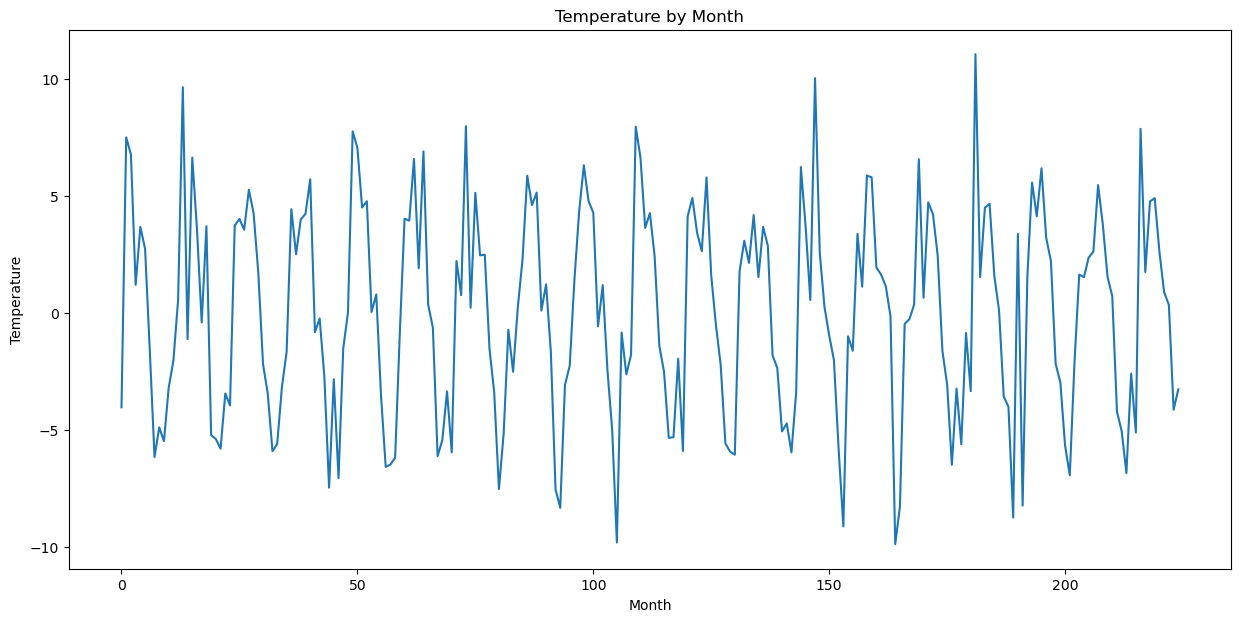

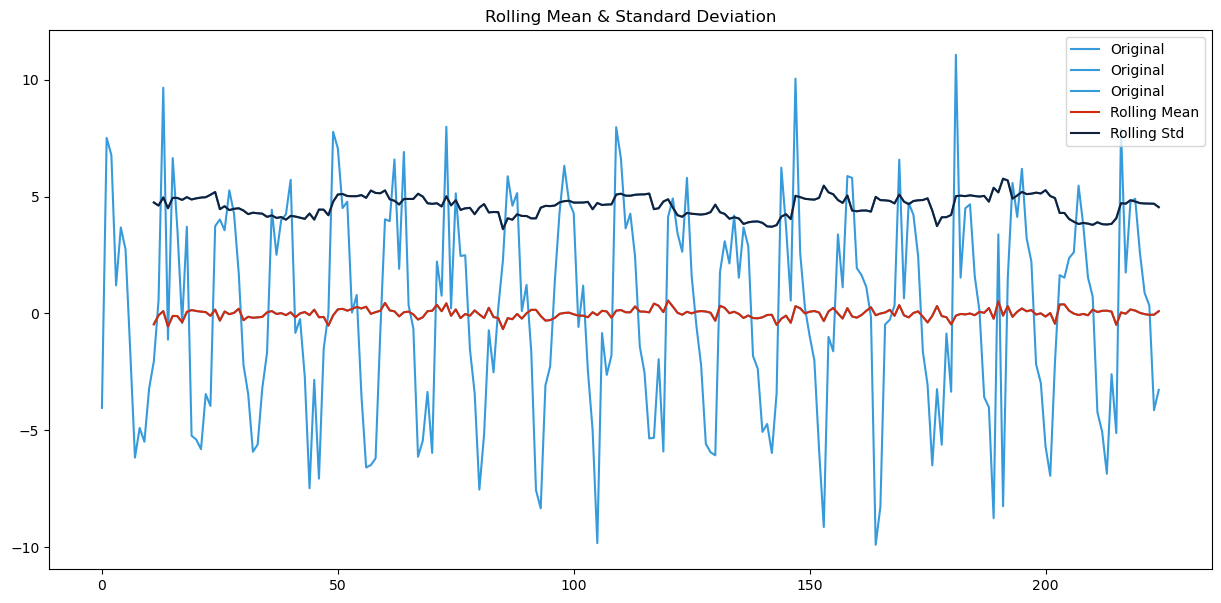

        0  rolling_avg  rolling_std
0   -4.04          NaN          NaN
1    7.51          NaN          NaN
2    6.78          NaN          NaN
3    1.20          NaN          NaN
4    3.68          NaN          NaN
..    ...          ...          ...
220  2.61     0.025833     4.721734
221  0.88    -0.029167     4.706312
222  0.34    -0.060833     4.702089
223 -4.14    -0.053333     4.694901
224 -3.27     0.095833     4.547490

[225 rows x 3 columns]
Results of Dickey Fuller Test for temperature:
Test Statistic                -1.353116e+01
p-value                        2.620039e-25
#Lags Used                     1.000000e+01
Number of Observations Used    2.140000e+02
Critical Value (1%)           -3.461282e+00
Critical Value (5%)           -2.875143e+00
Critical Value (10%)          -2.574020e+00
dtype: float64
Results of Dickey Fuller Test for temperature:
Test Statistic                  -2.284538
p-value                          0.177003
#Lags Used                      11.000000
N

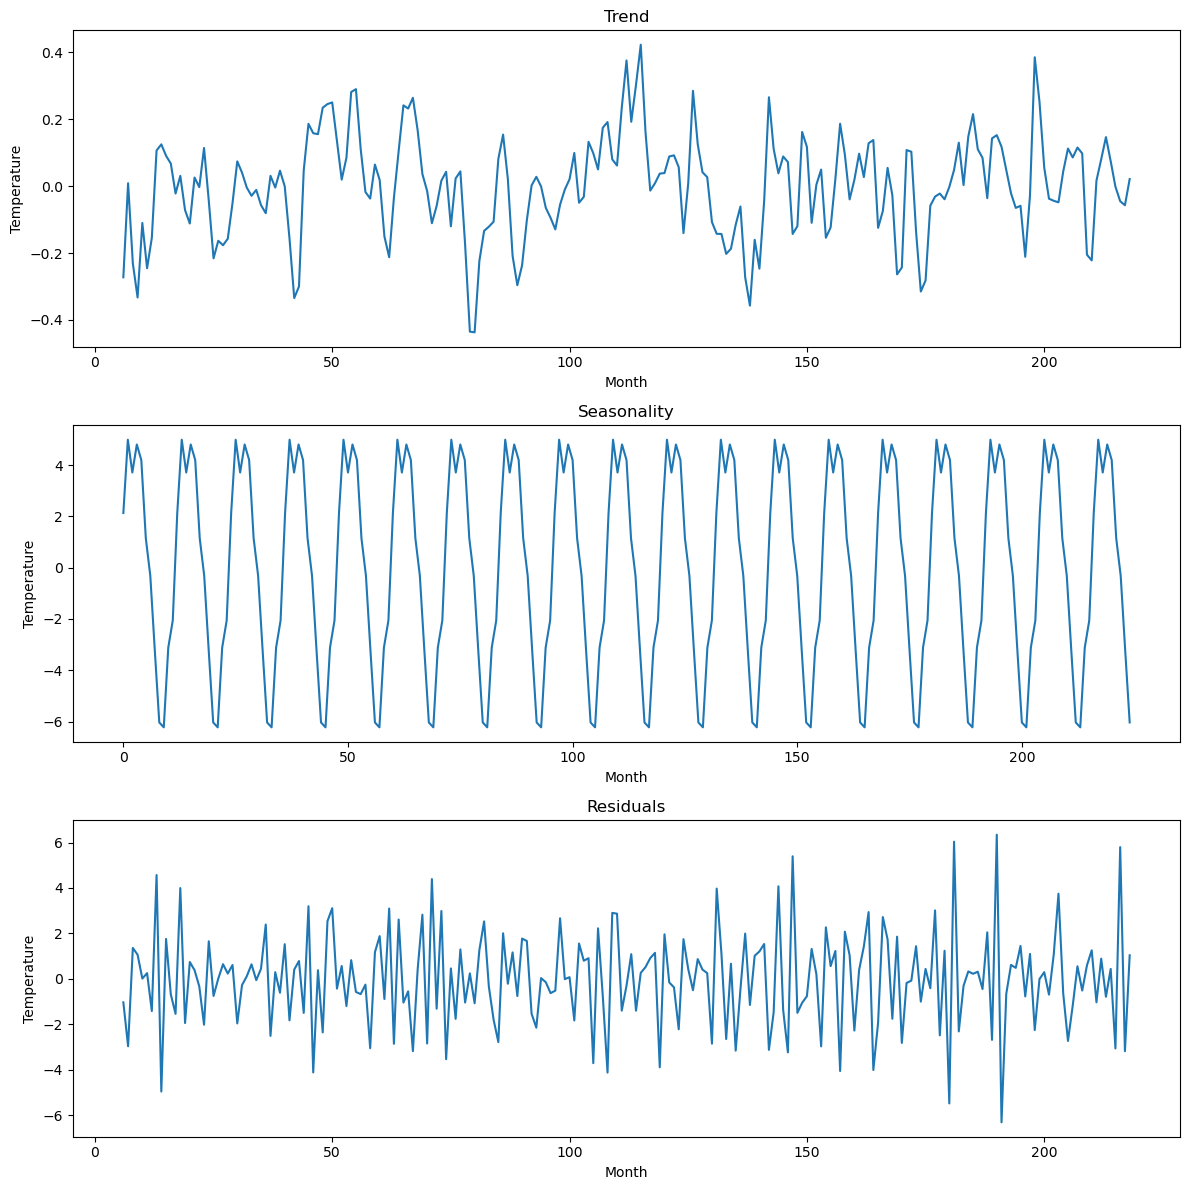

1
Fold 2:
(225, 1)


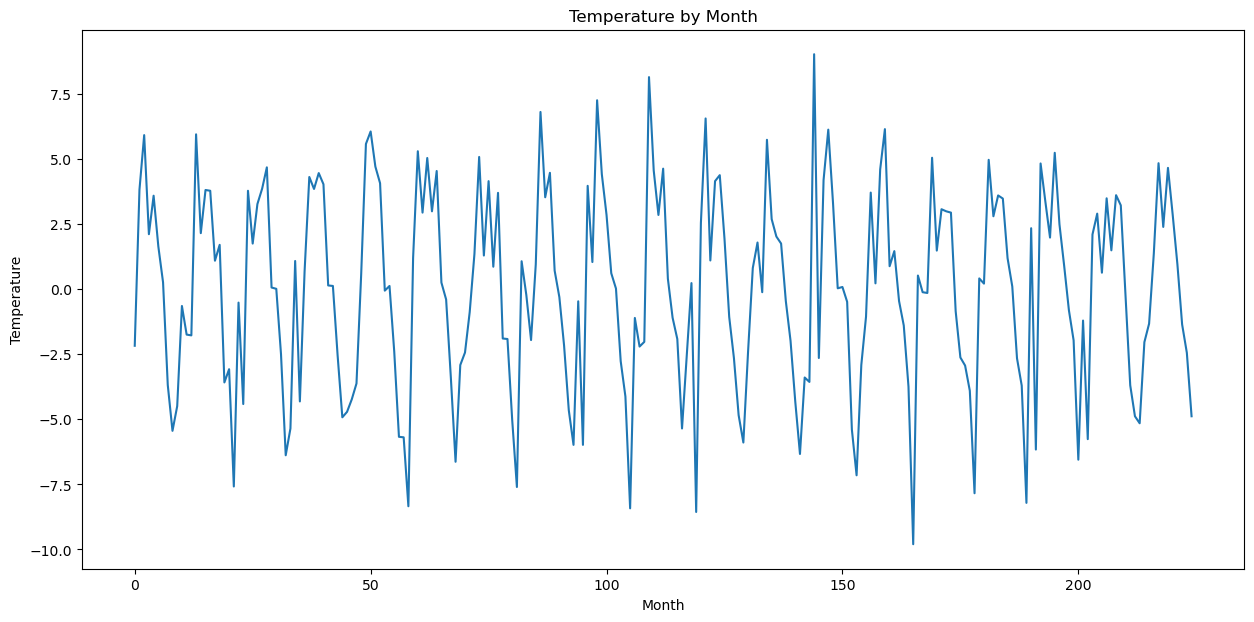

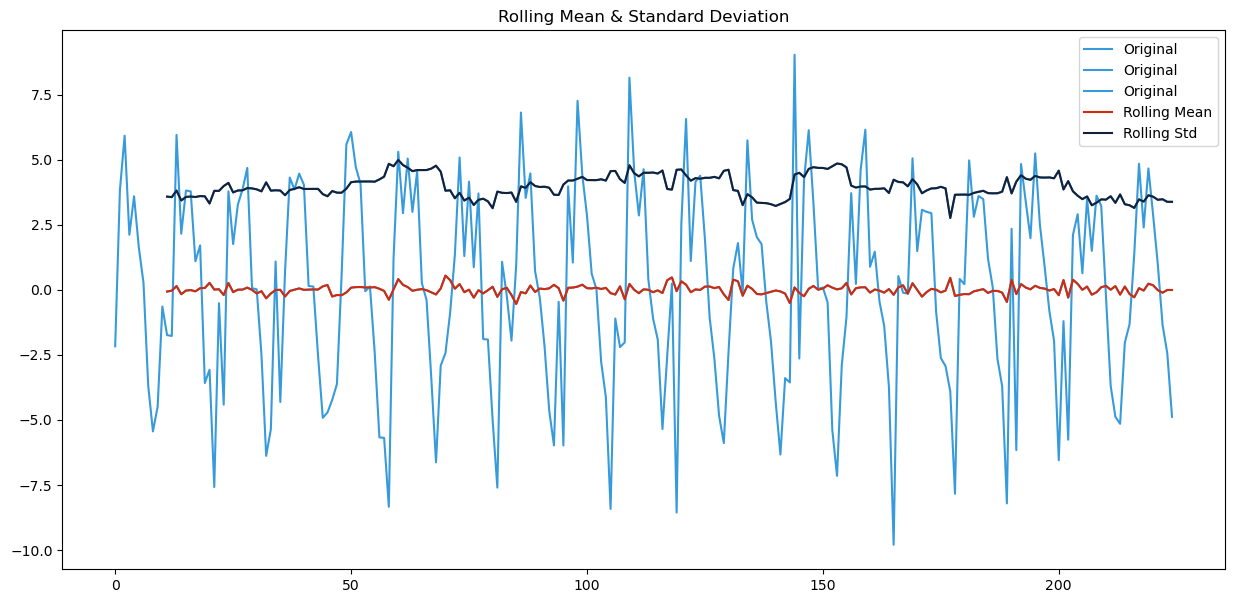

        0  rolling_avg  rolling_std
0   -2.17          NaN          NaN
1    3.83          NaN          NaN
2    5.93          NaN          NaN
3    2.12          NaN          NaN
4    3.60          NaN          NaN
..    ...          ...          ...
220  2.87     0.176667     3.582171
221  0.96    -0.012500     3.464270
222 -1.35    -0.107500     3.485743
223 -2.44    -0.003333     3.386208
224 -4.88    -0.003333     3.386208

[225 rows x 3 columns]
Results of Dickey Fuller Test for temperature:
Test Statistic                -1.133980e+01
p-value                        1.061468e-20
#Lags Used                     1.100000e+01
Number of Observations Used    2.130000e+02
Critical Value (1%)           -3.461429e+00
Critical Value (5%)           -2.875207e+00
Critical Value (10%)          -2.574054e+00
dtype: float64
Results of Dickey Fuller Test for temperature:
Test Statistic                  -2.284538
p-value                          0.177003
#Lags Used                      11.000000
N

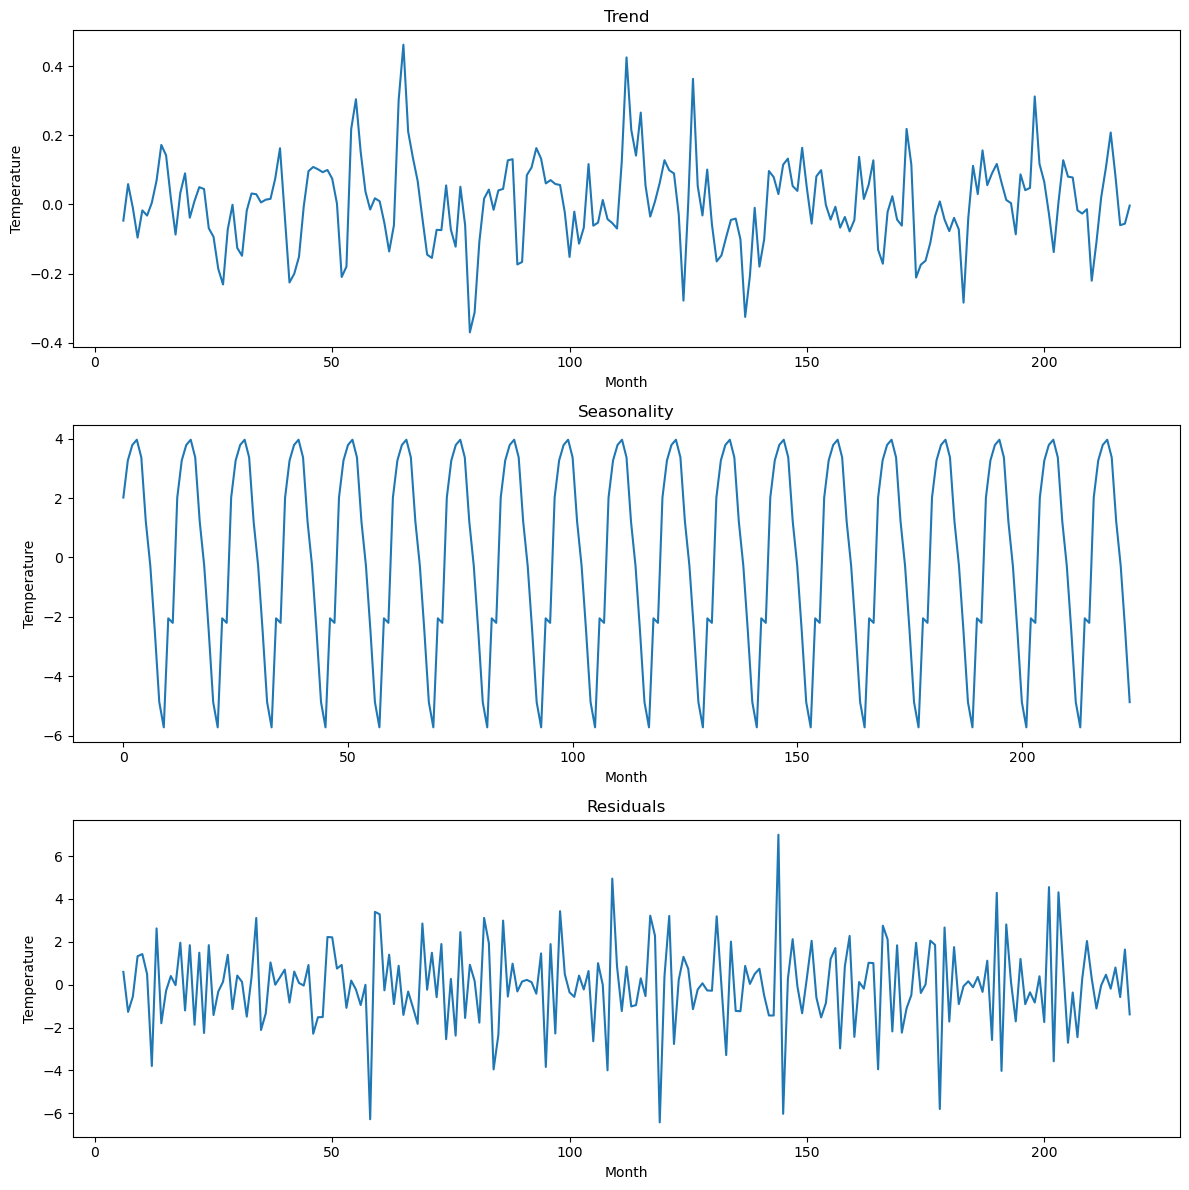

2
Fold 3:
(225, 1)


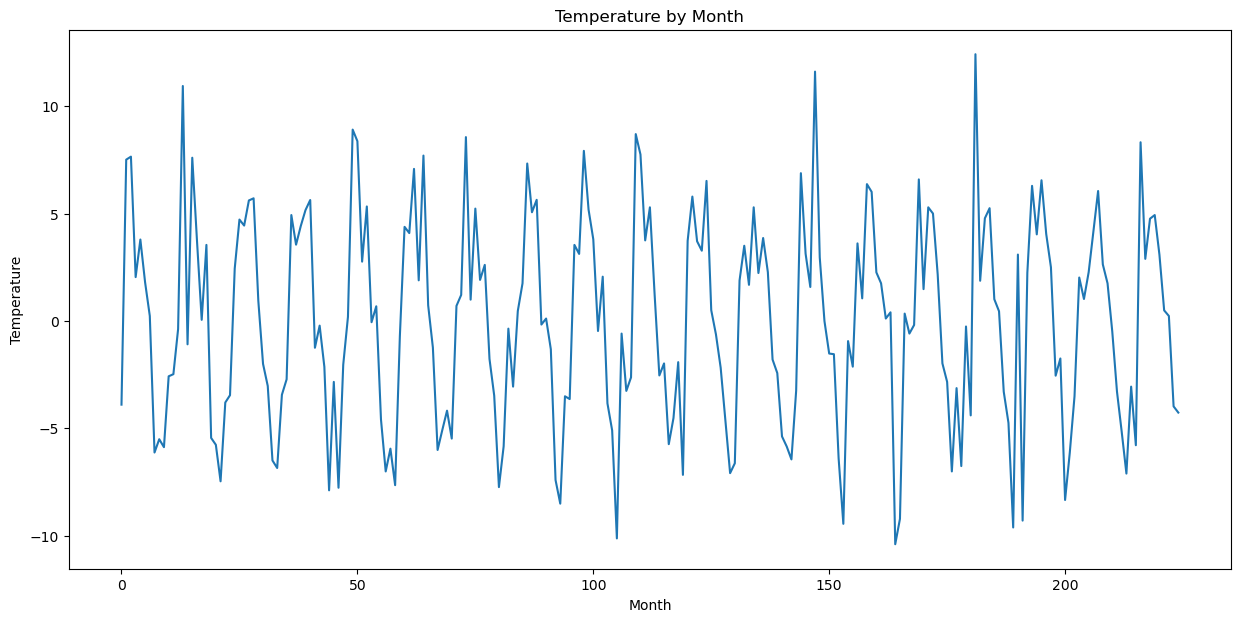

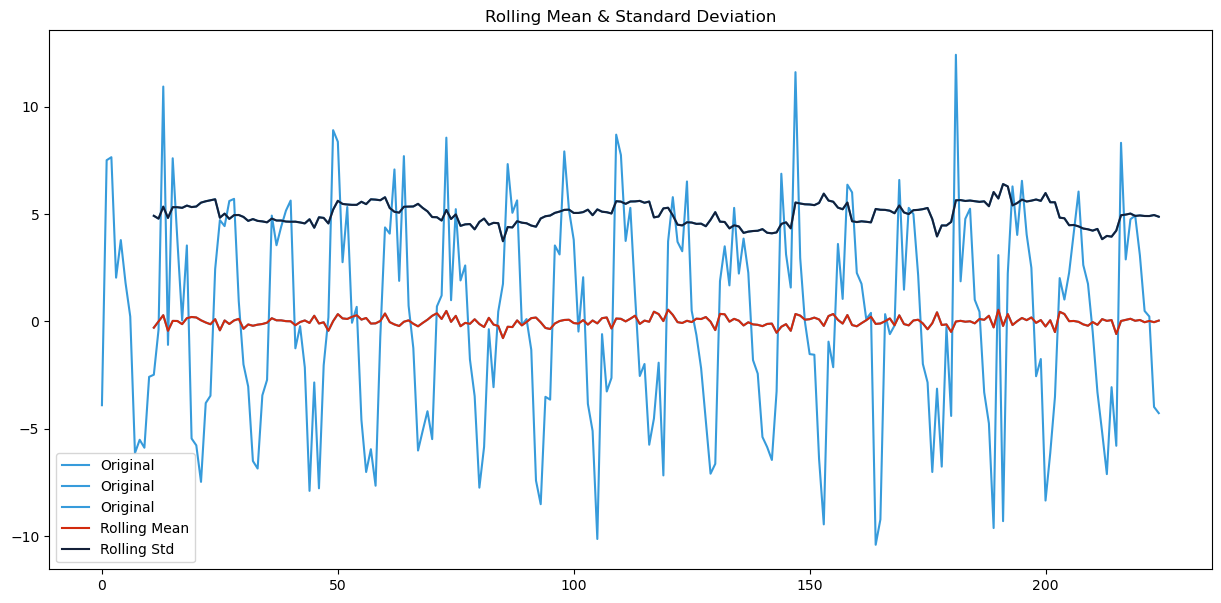

        0  rolling_avg  rolling_std
0   -3.90          NaN          NaN
1    7.51          NaN          NaN
2    7.65          NaN          NaN
3    2.04          NaN          NaN
4    3.79          NaN          NaN
..    ...          ...          ...
220  3.08     0.069167     4.937409
221  0.49    -0.035833     4.911746
222  0.23     0.024167     4.910091
223 -3.98    -0.033333     4.956253
224 -4.27     0.040833     4.878613

[225 rows x 3 columns]
Results of Dickey Fuller Test for temperature:
Test Statistic                -1.354973e+01
p-value                        2.422497e-25
#Lags Used                     1.000000e+01
Number of Observations Used    2.140000e+02
Critical Value (1%)           -3.461282e+00
Critical Value (5%)           -2.875143e+00
Critical Value (10%)          -2.574020e+00
dtype: float64
Results of Dickey Fuller Test for temperature:
Test Statistic                  -2.284538
p-value                          0.177003
#Lags Used                      11.000000
N

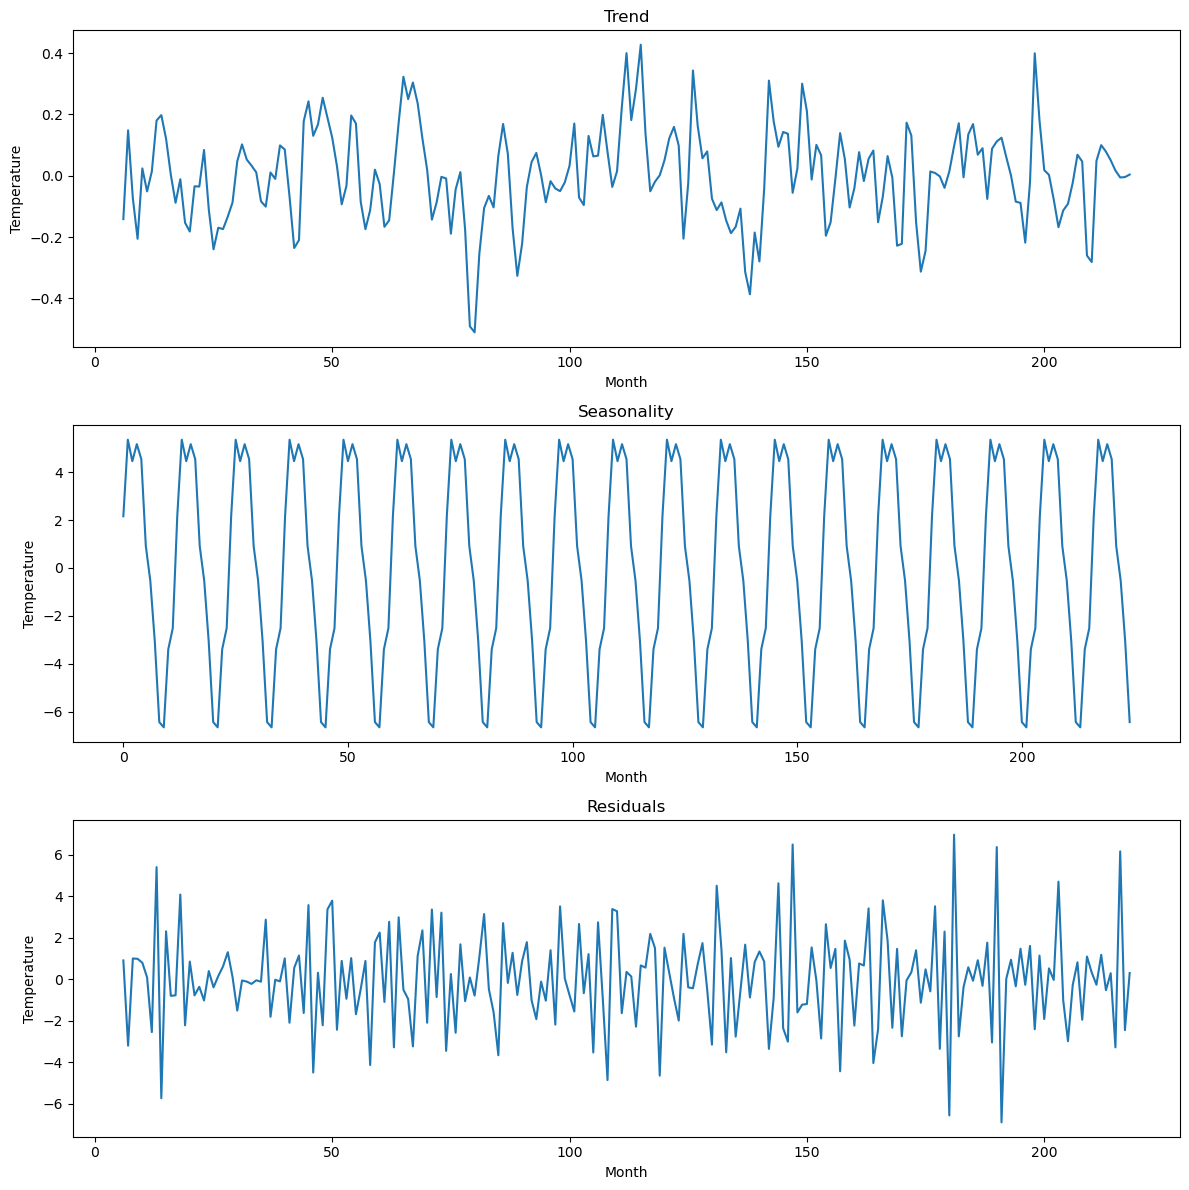

3
Fold 4:
(225, 1)


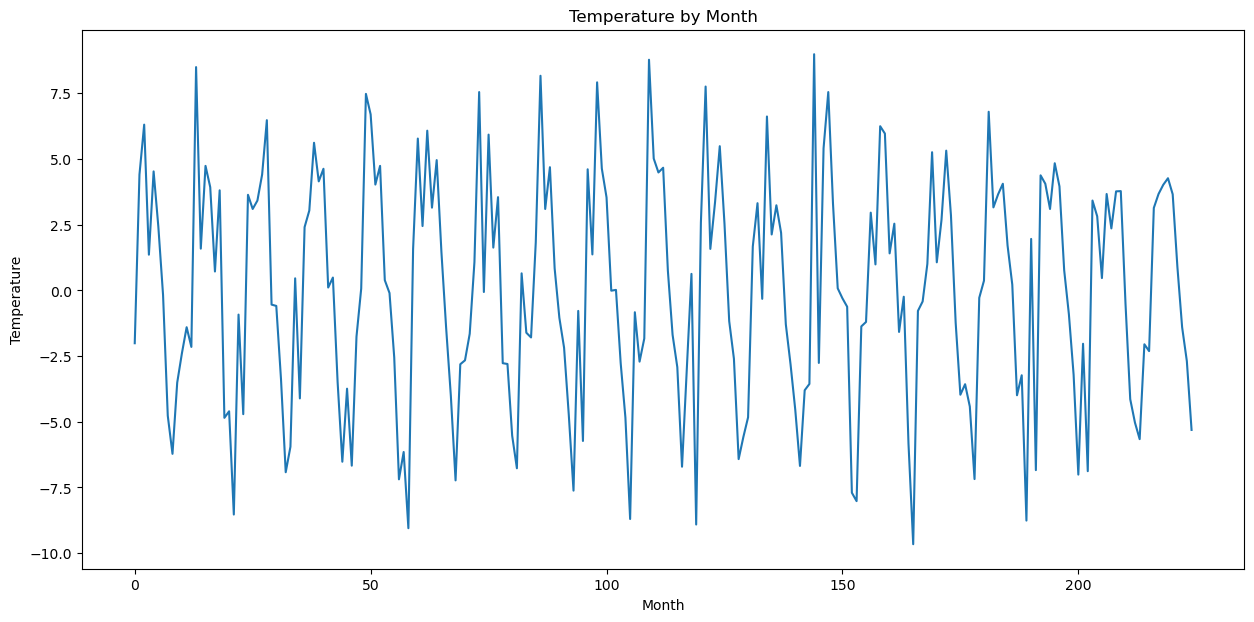

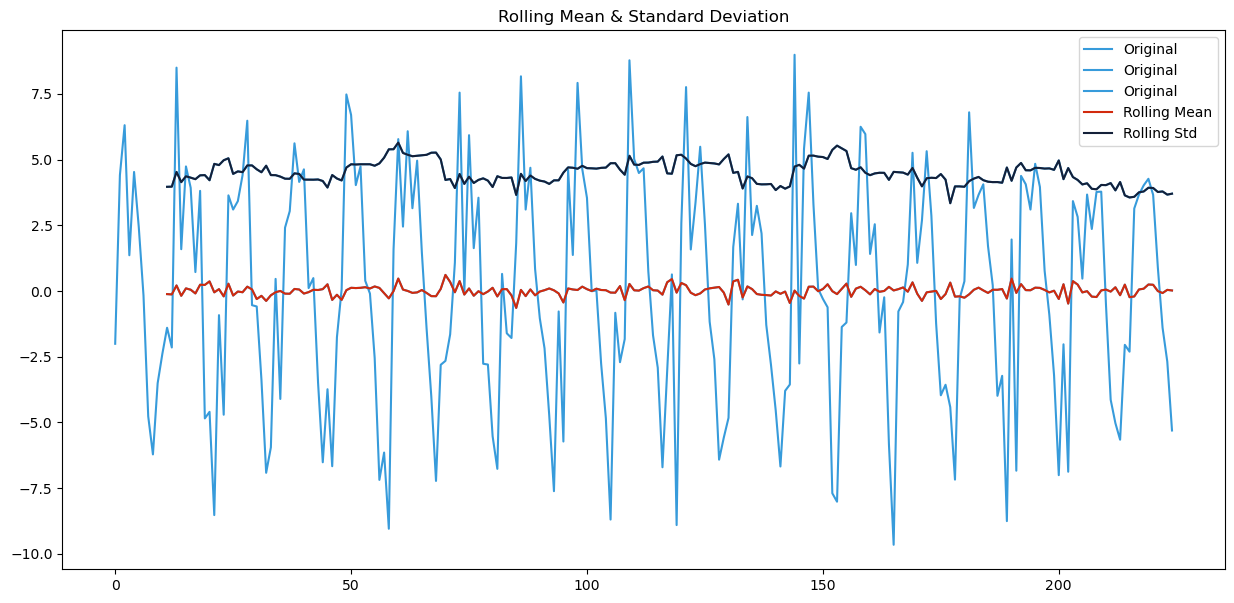

        0  rolling_avg  rolling_std
0   -2.01          NaN          NaN
1    4.41          NaN          NaN
2    6.31          NaN          NaN
3    1.36          NaN          NaN
4    4.53          NaN          NaN
..    ...          ...          ...
220  3.66     0.236667     3.919746
221  0.89    -0.004167     3.768097
222 -1.40    -0.078333     3.787666
223 -2.69     0.042500     3.667536
224 -5.31     0.019167     3.703457

[225 rows x 3 columns]
Results of Dickey Fuller Test for temperature:
Test Statistic                -1.165941e+01
p-value                        1.949655e-21
#Lags Used                     1.100000e+01
Number of Observations Used    2.130000e+02
Critical Value (1%)           -3.461429e+00
Critical Value (5%)           -2.875207e+00
Critical Value (10%)          -2.574054e+00
dtype: float64
Results of Dickey Fuller Test for temperature:
Test Statistic                  -2.284538
p-value                          0.177003
#Lags Used                      11.000000
N

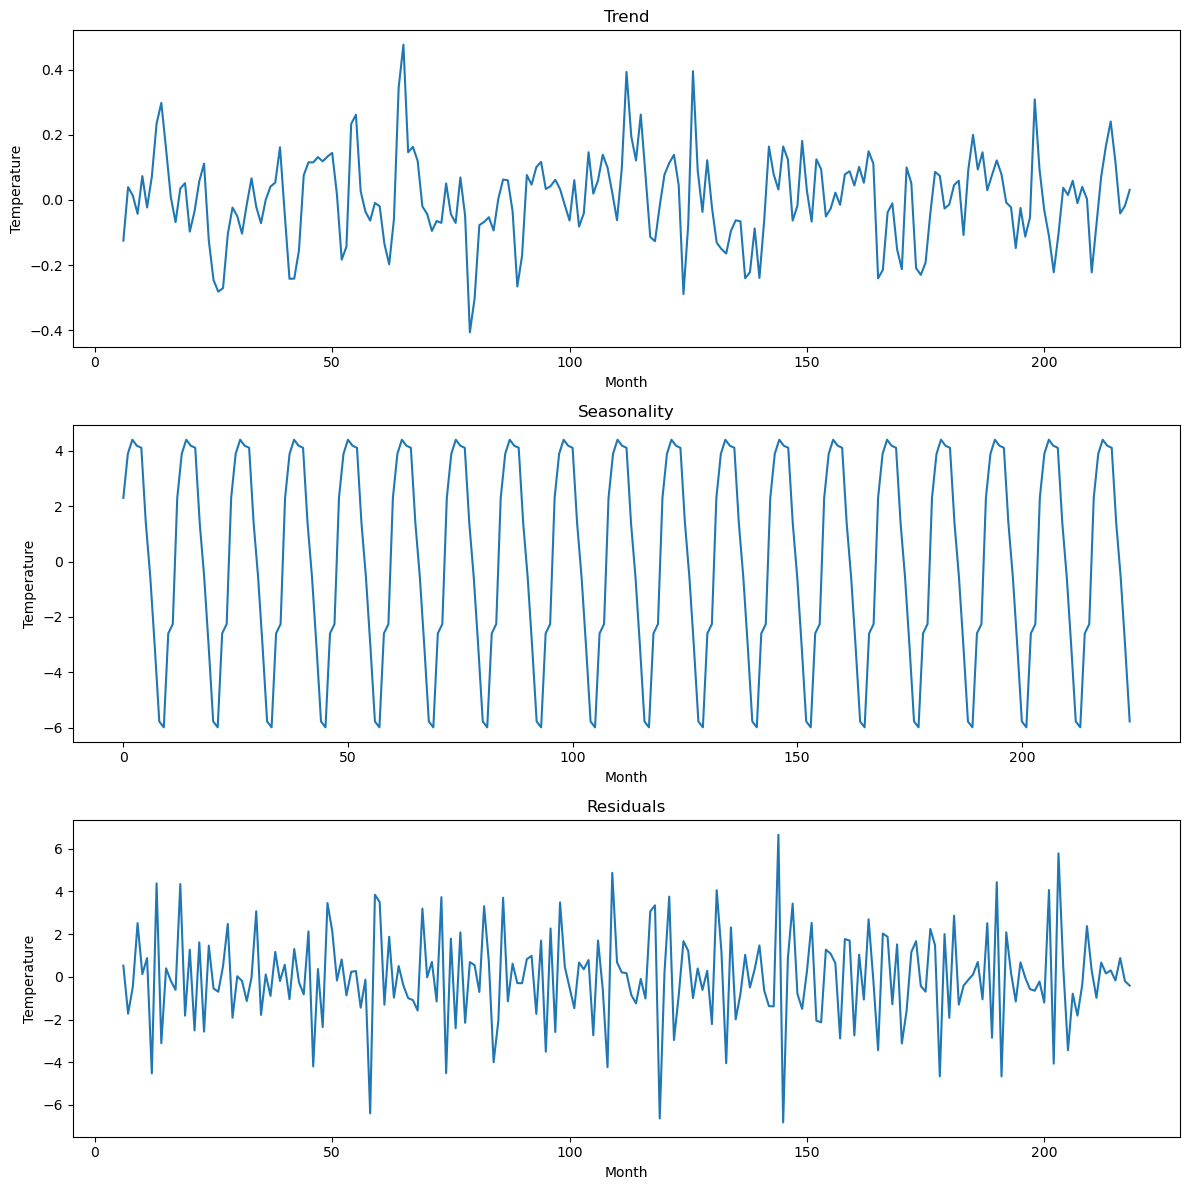

4
Fold 5:
(225, 1)


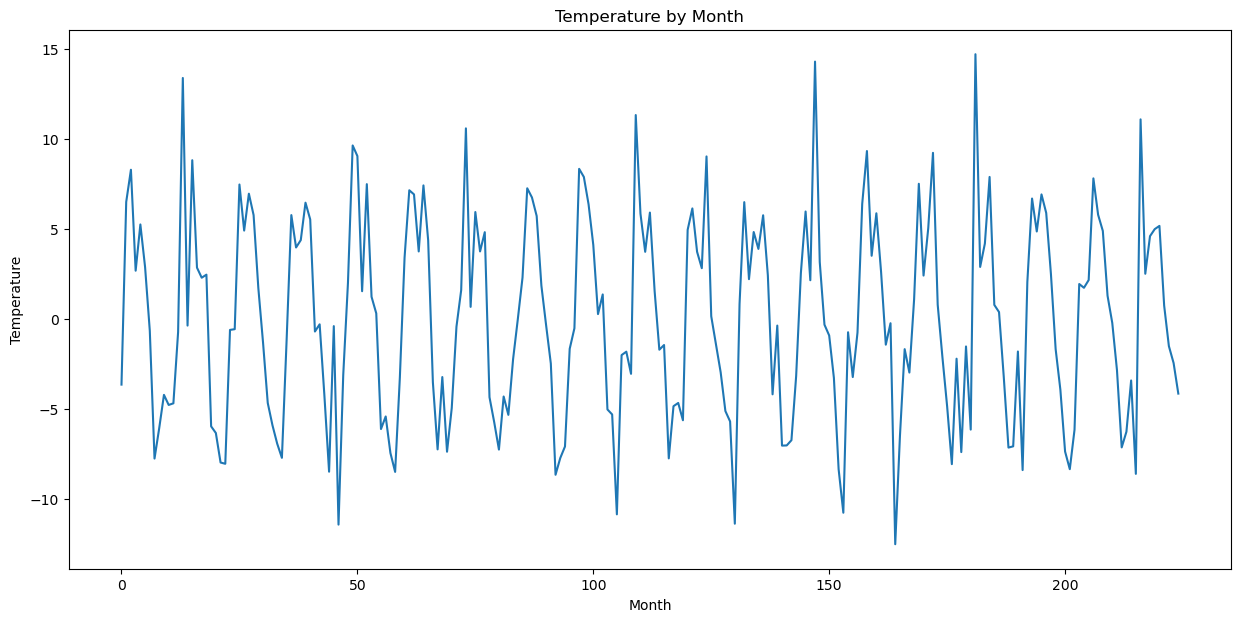

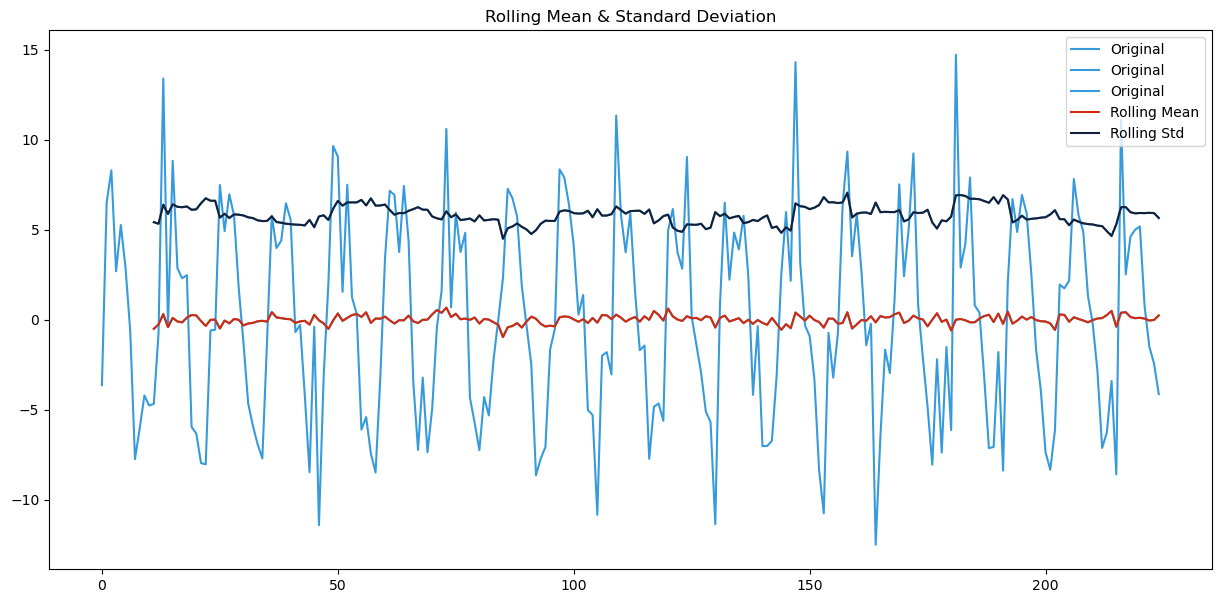

        0  rolling_avg  rolling_std
0   -3.63          NaN          NaN
1    6.52          NaN          NaN
2    8.31          NaN          NaN
3    2.70          NaN          NaN
4    5.27          NaN          NaN
..    ...          ...          ...
220  5.19     0.115000     5.938510
221  0.76     0.069167     5.930566
222 -1.49    -0.038333     5.947555
223 -2.43    -0.005000     5.931586
224 -4.13     0.244167     5.662222

[225 rows x 3 columns]
Results of Dickey Fuller Test for temperature:
Test Statistic                -1.239355e+01
p-value                        4.730116e-23
#Lags Used                     1.000000e+01
Number of Observations Used    2.140000e+02
Critical Value (1%)           -3.461282e+00
Critical Value (5%)           -2.875143e+00
Critical Value (10%)          -2.574020e+00
dtype: float64
Results of Dickey Fuller Test for temperature:
Test Statistic                  -2.284538
p-value                          0.177003
#Lags Used                      11.000000
N

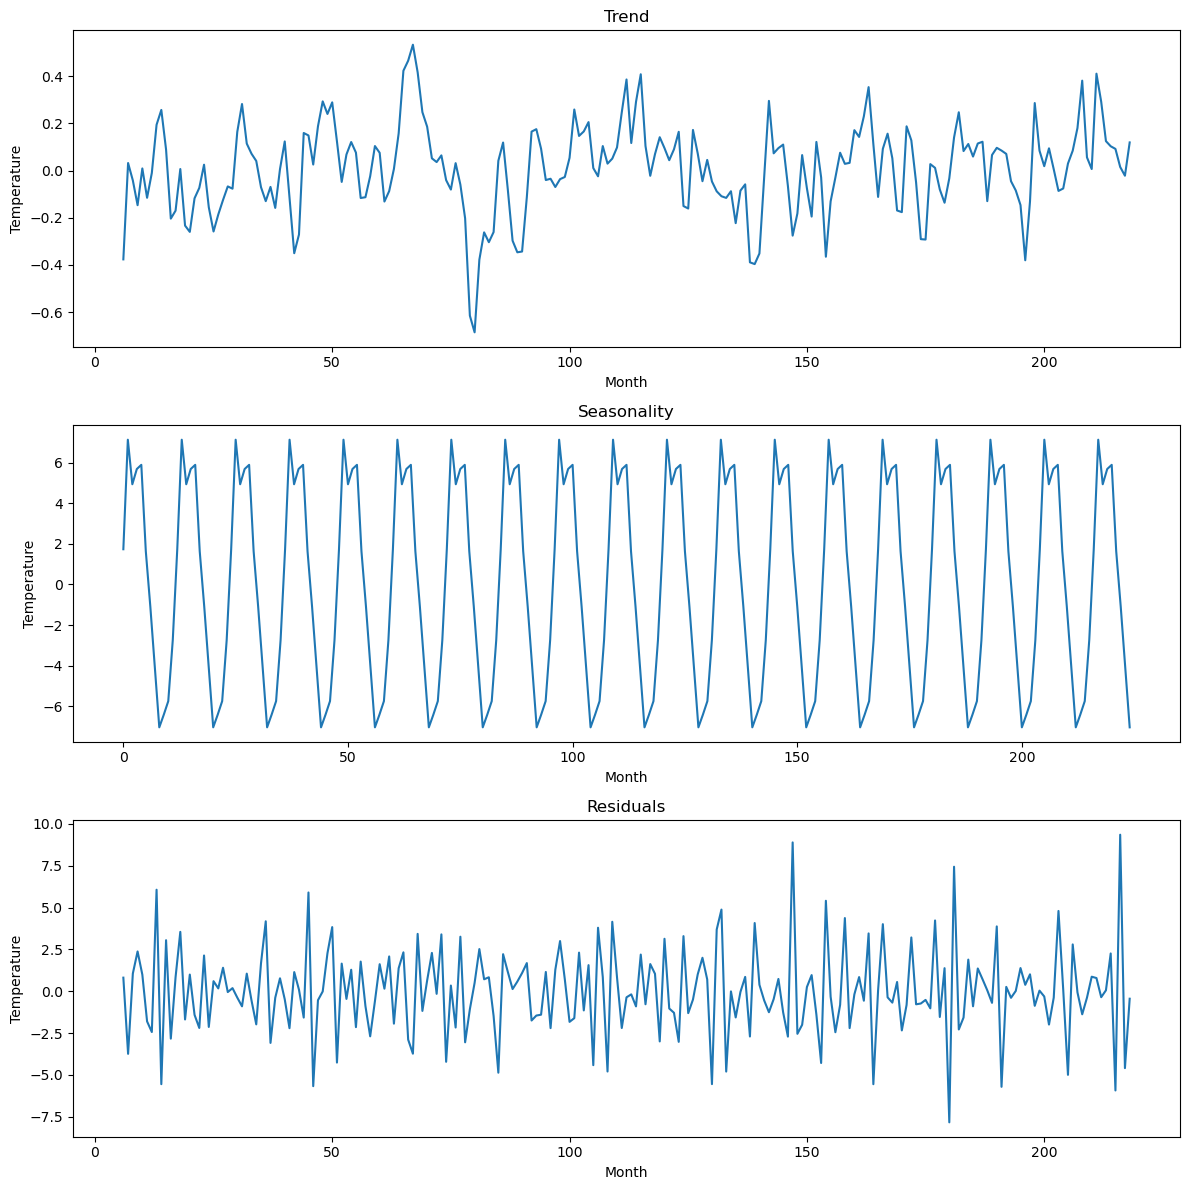

5
0      0.701397
1      0.755772
2      0.585358
3      0.663426
4      0.591434
         ...   
174    0.356318
175    0.258809
176    0.436817
177    0.279162
178    0.457473
Name: 0, Length: 179, dtype: float64
0      0.733475
1      0.711240
2      0.541273
3      0.616814
4      0.588182
         ...   
174    0.411514
175    0.306732
176    0.406031
177    0.333536
178    0.478526
Name: 0, Length: 179, dtype: float64
ARIMA Temperature Predictions:


C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:                        SARIMAX   Log Likelihood                 427.067
Date:                Thu, 15 May 2025   AIC                           -850.134
Time:                        17:30:05   BIC                           -839.025
Sample:                             0   HQIC                          -846.045
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4718      0.005     96.661      0.000       0.462       0.481
sigma2         0.0374      0.001     29.665      0.000       0.035       0.040
Ljung-Box (L1) (Q):                 979.86   Jarque-

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:                        SARIMAX   Log Likelihood                 382.507
Date:                Thu, 15 May 2025   AIC                           -761.015
Time:                        17:30:07   BIC                           -749.905
Sample:                             0   HQIC                          -756.926
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4731      0.005     96.457      0.000       0.463       0.483
sigma2         0.0392      0.001     29.108      0.000       0.037       0.042
Ljung-Box (L1) (Q):                 988.20   Jarque-

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:                        SARIMAX   Log Likelihood                 384.817
Date:                Thu, 15 May 2025   AIC                           -765.634
Time:                        17:30:10   BIC                           -754.524
Sample:                             0   HQIC                          -761.545
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4718      0.005     97.058      0.000       0.462       0.481
sigma2         0.0391      0.001     29.011      0.000       0.036       0.042
Ljung-Box (L1) (Q):                 968.63   Jarque-

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:                        SARIMAX   Log Likelihood                 370.858
Date:                Thu, 15 May 2025   AIC                           -737.717
Time:                        17:30:13   BIC                           -726.607
Sample:                             0   HQIC                          -733.628
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4533      0.005     93.231      0.000       0.444       0.463
sigma2         0.0397      0.001     27.914      0.000       0.037       0.042
Ljung-Box (L1) (Q):                 898.60   Jarque-

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:                        SARIMAX   Log Likelihood                 339.836
Date:                Thu, 15 May 2025   AIC                           -675.672
Time:                        17:30:15   BIC                           -664.562
Sample:                             0   HQIC                          -671.583
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4719      0.005     94.762      0.000       0.462       0.482
sigma2         0.0410      0.001     28.205      0.000       0.038       0.044
Ljung-Box (L1) (Q):                 943.77   Jarque-

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 827.043
Date:                Thu, 15 May 2025   AIC                          -1648.086
Time:                        17:30:21   BIC                          -1631.421
Sample:                             0   HQIC                         -1641.953
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4718      0.006     82.125      0.000       0.460       0.483
ma.L1          0.5158      0.019     26.732      0.000       0.478       0.554
sigma2         0.0246      0.001     32.527      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 803.022
Date:                Thu, 15 May 2025   AIC                          -1600.044
Time:                        17:30:27   BIC                          -1583.380
Sample:                             0   HQIC                         -1593.911
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4730      0.006     81.619      0.000       0.462       0.484
ma.L1          0.5435      0.019     28.418      0.000       0.506       0.581
sigma2         0.0252      0.001     32.871      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 790.755
Date:                Thu, 15 May 2025   AIC                          -1575.511
Time:                        17:30:33   BIC                          -1558.846
Sample:                             0   HQIC                         -1569.377
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4717      0.006     81.447      0.000       0.460       0.483
ma.L1          0.5326      0.019     27.396      0.000       0.494       0.571
sigma2         0.0256      0.001     31.922      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 729.634
Date:                Thu, 15 May 2025   AIC                          -1453.269
Time:                        17:30:39   BIC                          -1436.604
Sample:                             0   HQIC                         -1447.135
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4533      0.006     77.278      0.000       0.442       0.465
ma.L1          0.4864      0.019     25.919      0.000       0.450       0.523
sigma2         0.0273      0.001     31.636      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 731.380
Date:                Thu, 15 May 2025   AIC                          -1456.761
Time:                        17:30:45   BIC                          -1440.096
Sample:                             0   HQIC                         -1450.627
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4718      0.006     79.753      0.000       0.460       0.483
ma.L1          0.5162      0.019     27.015      0.000       0.479       0.554
sigma2         0.0272      0.001     31.865      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(0, 0, 2)   Log Likelihood                1034.294
Date:                Thu, 15 May 2025   AIC                          -2060.587
Time:                        17:30:56   BIC                          -2038.368
Sample:                             0   HQIC                         -2052.410
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4717      0.007     70.878      0.000       0.459       0.485
ma.L1          0.5750      0.020     29.187      0.000       0.536       0.614
ma.L2          0.4299      0.021     20.414      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(0, 0, 2)   Log Likelihood                 984.336
Date:                Thu, 15 May 2025   AIC                          -1960.673
Time:                        17:31:07   BIC                          -1938.453
Sample:                             0   HQIC                         -1952.495
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4729      0.007     68.240      0.000       0.459       0.487
ma.L1          0.5800      0.021     27.647      0.000       0.539       0.621
ma.L2          0.4122      0.022     18.568      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(0, 0, 2)   Log Likelihood                 972.431
Date:                Thu, 15 May 2025   AIC                          -1936.862
Time:                        17:31:18   BIC                          -1914.642
Sample:                             0   HQIC                         -1928.684
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4717      0.007     68.353      0.000       0.458       0.485
ma.L1          0.5689      0.021     27.723      0.000       0.529       0.609
ma.L2          0.4130      0.023     18.347      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(0, 0, 2)   Log Likelihood                 922.803
Date:                Thu, 15 May 2025   AIC                          -1837.606
Time:                        17:31:32   BIC                          -1815.386
Sample:                             0   HQIC                         -1829.428
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4532      0.007     65.060      0.000       0.440       0.467
ma.L1          0.5473      0.020     27.089      0.000       0.508       0.587
ma.L2          0.4116      0.022     18.612      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(0, 0, 2)   Log Likelihood                 915.356
Date:                Thu, 15 May 2025   AIC                          -1822.713
Time:                        17:31:43   BIC                          -1800.493
Sample:                             0   HQIC                         -1814.535
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4717      0.007     66.172      0.000       0.458       0.486
ma.L1          0.5679      0.021     27.100      0.000       0.527       0.609
ma.L2          0.4073      0.023     18.084      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(0, 0, 3)   Log Likelihood                1129.549
Date:                Thu, 15 May 2025   AIC                          -2249.098
Time:                        17:32:07   BIC                          -2221.324
Sample:                             0   HQIC                         -2238.876
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4717      0.008     62.779      0.000       0.457       0.486
ma.L1          0.5695      0.021     27.250      0.000       0.529       0.610
ma.L2          0.5089      0.022     23.071      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(0, 0, 3)   Log Likelihood                1095.914
Date:                Thu, 15 May 2025   AIC                          -2181.828
Time:                        17:32:25   BIC                          -2154.054
Sample:                             0   HQIC                         -2171.606
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4729      0.008     60.160      0.000       0.458       0.488
ma.L1          0.5760      0.022     26.499      0.000       0.533       0.619
ma.L2          0.4864      0.023     20.767      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(0, 0, 3)   Log Likelihood                1082.574
Date:                Thu, 15 May 2025   AIC                          -2155.147
Time:                        17:32:46   BIC                          -2127.373
Sample:                             0   HQIC                         -2144.925
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4717      0.008     59.623      0.000       0.456       0.487
ma.L1          0.5544      0.022     25.299      0.000       0.511       0.597
ma.L2          0.4806      0.023     20.933      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(0, 0, 3)   Log Likelihood                1001.120
Date:                Thu, 15 May 2025   AIC                          -1992.240
Time:                        17:33:08   BIC                          -1964.466
Sample:                             0   HQIC                         -1982.018
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4532      0.008     57.934      0.000       0.438       0.469
ma.L1          0.5475      0.021     26.473      0.000       0.507       0.588
ma.L2          0.4874      0.024     20.620      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(0, 0, 3)   Log Likelihood                1006.685
Date:                Thu, 15 May 2025   AIC                          -2003.370
Time:                        17:33:27   BIC                          -1975.595
Sample:                             0   HQIC                         -1993.148
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4717      0.008     58.928      0.000       0.456       0.487
ma.L1          0.5767      0.021     26.921      0.000       0.535       0.619
ma.L2          0.4895      0.024     20.296      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(0, 0, 4)   Log Likelihood                1207.045
Date:                Thu, 15 May 2025   AIC                          -2402.090
Time:                        17:33:54   BIC                          -2368.761
Sample:                             0   HQIC                         -2389.824
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4715      0.009     53.004      0.000       0.454       0.489
ma.L1          0.5966      0.020     29.466      0.000       0.557       0.636
ma.L2          0.6161      0.023     26.482      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(0, 0, 4)   Log Likelihood                1169.043
Date:                Thu, 15 May 2025   AIC                          -2326.086
Time:                        17:34:19   BIC                          -2292.757
Sample:                             0   HQIC                         -2313.820
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4728      0.009     50.868      0.000       0.455       0.491
ma.L1          0.5988      0.021     28.612      0.000       0.558       0.640
ma.L2          0.5973      0.023     25.567      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(0, 0, 4)   Log Likelihood                1157.123
Date:                Thu, 15 May 2025   AIC                          -2302.245
Time:                        17:34:43   BIC                          -2268.916
Sample:                             0   HQIC                         -2289.979
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4716      0.009     50.199      0.000       0.453       0.490
ma.L1          0.5770      0.021     26.996      0.000       0.535       0.619
ma.L2          0.5912      0.023     25.187      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(0, 0, 4)   Log Likelihood                1076.221
Date:                Thu, 15 May 2025   AIC                          -2140.443
Time:                        17:35:09   BIC                          -2107.114
Sample:                             0   HQIC                         -2128.177
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4531      0.009     47.875      0.000       0.435       0.472
ma.L1          0.5730      0.020     28.989      0.000       0.534       0.612
ma.L2          0.5994      0.024     24.775      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(0, 0, 4)   Log Likelihood                1077.189
Date:                Thu, 15 May 2025   AIC                          -2142.379
Time:                        17:35:32   BIC                          -2109.049
Sample:                             0   HQIC                         -2130.112
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4716      0.010     49.194      0.000       0.453       0.490
ma.L1          0.5947      0.021     28.950      0.000       0.554       0.635
ma.L2          0.5903      0.024     24.355      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(0, 0, 5)   Log Likelihood                1226.787
Date:                Thu, 15 May 2025   AIC                          -2439.573
Time:                        17:36:03   BIC                          -2400.689
Sample:                             0   HQIC                         -2425.262
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4715      0.010     47.237      0.000       0.452       0.491
ma.L1          0.6156      0.020     30.097      0.000       0.576       0.656
ma.L2          0.6733      0.027     24.847      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(0, 0, 5)   Log Likelihood                1197.237
Date:                Thu, 15 May 2025   AIC                          -2380.474
Time:                        17:36:35   BIC                          -2341.590
Sample:                             0   HQIC                         -2366.164
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4727      0.011     44.085      0.000       0.452       0.494
ma.L1          0.6260      0.021     29.574      0.000       0.584       0.667
ma.L2          0.6583      0.028     23.593      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(0, 0, 5)   Log Likelihood                1186.317
Date:                Thu, 15 May 2025   AIC                          -2358.635
Time:                        17:37:03   BIC                          -2319.751
Sample:                             0   HQIC                         -2344.324
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4716      0.011     43.426      0.000       0.450       0.493
ma.L1          0.6107      0.021     28.761      0.000       0.569       0.652
ma.L2          0.6556      0.029     22.344      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(0, 0, 5)   Log Likelihood                1086.378
Date:                Thu, 15 May 2025   AIC                          -2158.757
Time:                        17:37:30   BIC                          -2119.873
Sample:                             0   HQIC                         -2144.446
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4530      0.010     43.478      0.000       0.433       0.473
ma.L1          0.5917      0.020     29.059      0.000       0.552       0.632
ma.L2          0.6462      0.028     23.303      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(0, 0, 5)   Log Likelihood                1093.395
Date:                Thu, 15 May 2025   AIC                          -2172.790
Time:                        17:37:56   BIC                          -2133.906
Sample:                             0   HQIC                         -2158.479
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4716      0.011     43.659      0.000       0.450       0.493
ma.L1          0.6156      0.021     29.459      0.000       0.575       0.657
ma.L2          0.6485      0.028     22.929      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(0, 0, 6)   Log Likelihood                1231.946
Date:                Thu, 15 May 2025   AIC                          -2447.893
Time:                        17:38:40   BIC                          -2403.454
Sample:                             0   HQIC                         -2431.538
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4716      0.011     42.602      0.000       0.450       0.493
ma.L1          0.6235      0.021     30.334      0.000       0.583       0.664
ma.L2          0.6843      0.028     24.206      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(0, 0, 6)   Log Likelihood                1201.152
Date:                Thu, 15 May 2025   AIC                          -2386.304
Time:                        17:39:18   BIC                          -2341.865
Sample:                             0   HQIC                         -2369.949
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4727      0.012     39.760      0.000       0.449       0.496
ma.L1          0.6303      0.021     29.627      0.000       0.589       0.672
ma.L2          0.6677      0.029     23.200      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(0, 0, 6)   Log Likelihood                1188.801
Date:                Thu, 15 May 2025   AIC                          -2361.602
Time:                        17:39:53   BIC                          -2317.163
Sample:                             0   HQIC                         -2345.247
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4716      0.012     39.577      0.000       0.448       0.495
ma.L1          0.6127      0.022     28.467      0.000       0.571       0.655
ma.L2          0.6609      0.030     21.858      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(0, 0, 6)   Log Likelihood                1088.331
Date:                Thu, 15 May 2025   AIC                          -2160.663
Time:                        17:40:26   BIC                          -2116.224
Sample:                             0   HQIC                         -2144.308
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4530      0.011     40.499      0.000       0.431       0.475
ma.L1          0.5996      0.020     29.263      0.000       0.559       0.640
ma.L2          0.6577      0.029     22.940      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(0, 0, 6)   Log Likelihood                1096.221
Date:                Thu, 15 May 2025   AIC                          -2176.441
Time:                        17:41:06   BIC                          -2132.003
Sample:                             0   HQIC                         -2160.086
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4715      0.012     39.879      0.000       0.448       0.495
ma.L1          0.6243      0.021     29.548      0.000       0.583       0.666
ma.L2          0.6607      0.029     22.505      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(0, 0, 7)   Log Likelihood                1232.342
Date:                Thu, 15 May 2025   AIC                          -2446.685
Time:                        17:42:01   BIC                          -2396.691
Sample:                             0   HQIC                         -2428.286
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4716      0.012     39.927      0.000       0.448       0.495
ma.L1          0.6232      0.021     30.317      0.000       0.583       0.663
ma.L2          0.6937      0.029     24.221      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(0, 0, 7)   Log Likelihood                1203.530
Date:                Thu, 15 May 2025   AIC                          -2389.060
Time:                        17:42:44   BIC                          -2339.066
Sample:                             0   HQIC                         -2370.660
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4727      0.013     35.642      0.000       0.447       0.499
ma.L1          0.6314      0.021     29.793      0.000       0.590       0.673
ma.L2          0.6913      0.029     23.743      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(0, 0, 7)   Log Likelihood                1191.644
Date:                Thu, 15 May 2025   AIC                          -2365.287
Time:                        17:43:29   BIC                          -2315.293
Sample:                             0   HQIC                         -2346.888
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4715      0.013     35.153      0.000       0.445       0.498
ma.L1          0.6126      0.021     28.698      0.000       0.571       0.654
ma.L2          0.6891      0.030     22.960      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(0, 0, 7)   Log Likelihood                1090.245
Date:                Thu, 15 May 2025   AIC                          -2162.490
Time:                        17:44:07   BIC                          -2112.496
Sample:                             0   HQIC                         -2144.091
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4531      0.010     44.481      0.000       0.433       0.473
ma.L1          0.5961      0.020     29.235      0.000       0.556       0.636
ma.L2          0.6359      0.028     22.810      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(0, 0, 7)   Log Likelihood                1096.606
Date:                Thu, 15 May 2025   AIC                          -2175.212
Time:                        17:45:00   BIC                          -2125.219
Sample:                             0   HQIC                         -2156.813
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4716      0.012     40.938      0.000       0.449       0.494
ma.L1          0.6228      0.021     29.586      0.000       0.582       0.664
ma.L2          0.6505      0.029     22.418      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(0, 0, 8)   Log Likelihood                1234.866
Date:                Thu, 15 May 2025   AIC                          -2449.731
Time:                        17:45:49   BIC                          -2394.182
Sample:                             0   HQIC                         -2429.287
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4714      0.015     32.439      0.000       0.443       0.500
ma.L1          0.6461      0.020     31.807      0.000       0.606       0.686
ma.L2          0.7630      0.028     27.059      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(0, 0, 8)   Log Likelihood                1204.351
Date:                Thu, 15 May 2025   AIC                          -2388.703
Time:                        17:46:42   BIC                          -2333.154
Sample:                             0   HQIC                         -2368.259
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4726      0.015     31.750      0.000       0.443       0.502
ma.L1          0.6437      0.021     30.399      0.000       0.602       0.685
ma.L2          0.7313      0.029     25.211      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(0, 0, 8)   Log Likelihood                1193.242
Date:                Thu, 15 May 2025   AIC                          -2366.483
Time:                        17:47:30   BIC                          -2310.935
Sample:                             0   HQIC                         -2346.039
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4715      0.016     29.808      0.000       0.440       0.502
ma.L1          0.6322      0.021     29.608      0.000       0.590       0.674
ma.L2          0.7424      0.030     24.660      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(0, 0, 8)   Log Likelihood                1090.390
Date:                Thu, 15 May 2025   AIC                          -2160.781
Time:                        17:48:14   BIC                          -2105.232
Sample:                             0   HQIC                         -2140.337
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4531      0.010     45.415      0.000       0.434       0.473
ma.L1          0.5941      0.021     28.888      0.000       0.554       0.634
ma.L2          0.6295      0.028     22.499      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(0, 0, 8)   Log Likelihood                1096.746
Date:                Thu, 15 May 2025   AIC                          -2173.493
Time:                        17:49:11   BIC                          -2117.944
Sample:                             0   HQIC                         -2153.049
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4716      0.011     42.237      0.000       0.450       0.493
ma.L1          0.6198      0.021     29.325      0.000       0.578       0.661
ma.L2          0.6404      0.029     22.165      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(0, 0, 9)   Log Likelihood                1256.681
Date:                Thu, 15 May 2025   AIC                          -2491.362
Time:                        17:50:12   BIC                          -2430.258
Sample:                             0   HQIC                         -2468.874
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4717      0.010     48.799      0.000       0.453       0.491
ma.L1          0.5707      0.020     29.035      0.000       0.532       0.609
ma.L2          0.6511      0.025     25.580      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(0, 0, 9)   Log Likelihood                1222.553
Date:                Thu, 15 May 2025   AIC                          -2423.105
Time:                        17:51:16   BIC                          -2362.002
Sample:                             0   HQIC                         -2400.617
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4729      0.010     46.824      0.000       0.453       0.493
ma.L1          0.5708      0.021     27.816      0.000       0.531       0.611
ma.L2          0.6201      0.026     23.870      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(0, 0, 9)   Log Likelihood                1215.650
Date:                Thu, 15 May 2025   AIC                          -2409.300
Time:                        17:52:19   BIC                          -2348.196
Sample:                             0   HQIC                         -2386.811
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4717      0.010     47.585      0.000       0.452       0.491
ma.L1          0.5571      0.020     27.369      0.000       0.517       0.597
ma.L2          0.6236      0.026     23.688      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(0, 0, 9)   Log Likelihood                1106.532
Date:                Thu, 15 May 2025   AIC                          -2191.064
Time:                        17:53:15   BIC                          -2129.960
Sample:                             0   HQIC                         -2168.575
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4532      0.009     48.459      0.000       0.435       0.472
ma.L1          0.5363      0.020     27.178      0.000       0.498       0.575
ma.L2          0.5971      0.026     22.676      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(0, 0, 9)   Log Likelihood                1112.048
Date:                Thu, 15 May 2025   AIC                          -2202.096
Time:                        17:54:18   BIC                          -2140.993
Sample:                             0   HQIC                         -2179.608
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4717      0.010     47.058      0.000       0.452       0.491
ma.L1          0.5630      0.020     27.653      0.000       0.523       0.603
ma.L2          0.6025      0.027     22.417      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:              SARIMAX(0, 0, 10)   Log Likelihood                1283.786
Date:                Thu, 15 May 2025   AIC                          -2543.573
Time:                        17:55:37   BIC                          -2476.914
Sample:                             0   HQIC                         -2519.040
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4717      0.009     53.622      0.000       0.454       0.489
ma.L1          0.5823      0.019     30.131      0.000       0.544       0.620
ma.L2          0.6524      0.024     27.575      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:              SARIMAX(0, 0, 10)   Log Likelihood                1260.506
Date:                Thu, 15 May 2025   AIC                          -2497.012
Time:                        17:56:43   BIC                          -2430.353
Sample:                             0   HQIC                         -2472.479
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4730      0.009     52.354      0.000       0.455       0.491
ma.L1          0.5844      0.020     29.607      0.000       0.546       0.623
ma.L2          0.6436      0.024     27.178      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:              SARIMAX(0, 0, 10)   Log Likelihood                1243.634
Date:                Thu, 15 May 2025   AIC                          -2463.268
Time:                        17:57:54   BIC                          -2396.609
Sample:                             0   HQIC                         -2438.735
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4717      0.009     51.256      0.000       0.454       0.490
ma.L1          0.5692      0.020     28.234      0.000       0.530       0.609
ma.L2          0.6313      0.025     25.435      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:              SARIMAX(0, 0, 10)   Log Likelihood                1149.058
Date:                Thu, 15 May 2025   AIC                          -2274.115
Time:                        17:59:26   BIC                          -2207.457
Sample:                             0   HQIC                         -2249.583
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4533      0.008     54.092      0.000       0.437       0.470
ma.L1          0.5403      0.018     29.233      0.000       0.504       0.576
ma.L2          0.6091      0.023     25.946      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:              SARIMAX(0, 0, 10)   Log Likelihood                1156.103
Date:                Thu, 15 May 2025   AIC                          -2288.205
Time:                        18:00:32   BIC                          -2221.547
Sample:                             0   HQIC                         -2263.673
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4718      0.009     53.213      0.000       0.454       0.489
ma.L1          0.5695      0.019     29.399      0.000       0.532       0.607
ma.L2          0.6110      0.024     25.589      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:              SARIMAX(0, 0, 11)   Log Likelihood                1287.751
Date:                Thu, 15 May 2025   AIC                          -2549.501
Time:                        18:02:00   BIC                          -2477.288
Sample:                             0   HQIC                         -2522.924
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4718      0.009     55.157      0.000       0.455       0.489
ma.L1          0.5890      0.020     30.185      0.000       0.551       0.627
ma.L2          0.6668      0.023     28.707      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:              SARIMAX(0, 0, 11)   Log Likelihood                1263.871
Date:                Thu, 15 May 2025   AIC                          -2501.742
Time:                        18:03:18   BIC                          -2429.529
Sample:                             0   HQIC                         -2475.165
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4731      0.009     53.945      0.000       0.456       0.490
ma.L1          0.5945      0.020     29.206      0.000       0.555       0.634
ma.L2          0.6573      0.023     28.271      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:              SARIMAX(0, 0, 11)   Log Likelihood                1248.383
Date:                Thu, 15 May 2025   AIC                          -2470.767
Time:                        18:04:42   BIC                          -2398.554
Sample:                             0   HQIC                         -2444.190
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4718      0.009     52.841      0.000       0.454       0.489
ma.L1          0.5742      0.020     28.106      0.000       0.534       0.614
ma.L2          0.6480      0.024     26.864      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:              SARIMAX(0, 0, 11)   Log Likelihood                1155.562
Date:                Thu, 15 May 2025   AIC                          -2285.123
Time:                        18:06:28   BIC                          -2212.910
Sample:                             0   HQIC                         -2258.546
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4534      0.008     56.171      0.000       0.438       0.469
ma.L1          0.5549      0.019     29.075      0.000       0.517       0.592
ma.L2          0.6296      0.023     27.426      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:              SARIMAX(0, 0, 11)   Log Likelihood                1161.007
Date:                Thu, 15 May 2025   AIC                          -2296.014
Time:                        18:07:48   BIC                          -2223.801
Sample:                             0   HQIC                         -2269.437
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4719      0.009     55.133      0.000       0.455       0.489
ma.L1          0.5802      0.020     29.079      0.000       0.541       0.619
ma.L2          0.6302      0.023     27.023      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:              SARIMAX(0, 0, 11)   Log Likelihood                1287.751
Date:                Thu, 15 May 2025   AIC                          -2549.501
Time:                        18:09:43   BIC                          -2477.288
Sample:                             0   HQIC                         -2522.924
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4718      0.009     55.157      0.000       0.455       0.489
ma.L1          0.5890      0.020     30.185      0.000       0.551       0.627
ma.L2          0.6668      0.023     28.707      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:              SARIMAX(0, 0, 11)   Log Likelihood                1263.871
Date:                Thu, 15 May 2025   AIC                          -2501.742
Time:                        18:11:36   BIC                          -2429.529
Sample:                             0   HQIC                         -2475.165
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4731      0.009     53.945      0.000       0.456       0.490
ma.L1          0.5945      0.020     29.206      0.000       0.555       0.634
ma.L2          0.6573      0.023     28.271      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:              SARIMAX(0, 0, 11)   Log Likelihood                1248.383
Date:                Thu, 15 May 2025   AIC                          -2470.767
Time:                        18:13:29   BIC                          -2398.554
Sample:                             0   HQIC                         -2444.190
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4718      0.009     52.841      0.000       0.454       0.489
ma.L1          0.5742      0.020     28.106      0.000       0.534       0.614
ma.L2          0.6480      0.024     26.864      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:              SARIMAX(0, 0, 11)   Log Likelihood                1155.562
Date:                Thu, 15 May 2025   AIC                          -2285.123
Time:                        18:15:51   BIC                          -2212.910
Sample:                             0   HQIC                         -2258.546
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4534      0.008     56.171      0.000       0.438       0.469
ma.L1          0.5549      0.019     29.075      0.000       0.517       0.592
ma.L2          0.6296      0.023     27.426      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:              SARIMAX(0, 0, 11)   Log Likelihood                1161.007
Date:                Thu, 15 May 2025   AIC                          -2296.014
Time:                        18:17:54   BIC                          -2223.801
Sample:                             0   HQIC                         -2269.437
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4719      0.009     55.133      0.000       0.455       0.489
ma.L1          0.5802      0.020     29.079      0.000       0.541       0.619
ma.L2          0.6302      0.023     27.023      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(1, 0, 0)   Log Likelihood                1116.098
Date:                Thu, 15 May 2025   AIC                          -2226.195
Time:                        18:18:01   BIC                          -2209.531
Sample:                             0   HQIC                         -2220.062
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1330      0.007     17.879      0.000       0.118       0.148
ar.L1          0.7179      0.016     45.958      0.000       0.687       0.749
sigma2         0.0182      0.001     36.192      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(1, 0, 0)   Log Likelihood                1079.733
Date:                Thu, 15 May 2025   AIC                          -2153.465
Time:                        18:18:05   BIC                          -2136.801
Sample:                             0   HQIC                         -2147.332
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1319      0.008     17.096      0.000       0.117       0.147
ar.L1          0.7209      0.016     44.884      0.000       0.689       0.752
sigma2         0.0189      0.001     36.444      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(1, 0, 0)   Log Likelihood                1062.416
Date:                Thu, 15 May 2025   AIC                          -2118.832
Time:                        18:18:09   BIC                          -2102.168
Sample:                             0   HQIC                         -2112.699
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1350      0.008     17.143      0.000       0.120       0.150
ar.L1          0.7137      0.016     44.036      0.000       0.682       0.745
sigma2         0.0192      0.001     34.852      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 979.044
Date:                Thu, 15 May 2025   AIC                          -1952.087
Time:                        18:18:13   BIC                          -1935.423
Sample:                             0   HQIC                         -1945.954
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1417      0.008     18.212      0.000       0.126       0.157
ar.L1          0.6872      0.017     40.474      0.000       0.654       0.721
sigma2         0.0210      0.001     35.610      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 991.747
Date:                Thu, 15 May 2025   AIC                          -1977.493
Time:                        18:18:17   BIC                          -1960.829
Sample:                             0   HQIC                         -1971.360
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1394      0.008     17.475      0.000       0.124       0.155
ar.L1          0.7044      0.017     42.231      0.000       0.672       0.737
sigma2         0.0207      0.001     35.761      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(1, 0, 1)   Log Likelihood                1118.412
Date:                Thu, 15 May 2025   AIC                          -2228.825
Time:                        18:18:35   BIC                          -2206.605
Sample:                             0   HQIC                         -2220.647
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1210      0.009     13.143      0.000       0.103       0.139
ar.L1          0.7434      0.020     37.224      0.000       0.704       0.783
ma.L1         -0.0514      0.031     -1.680      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(1, 0, 1)   Log Likelihood                1080.621
Date:                Thu, 15 May 2025   AIC                          -2153.243
Time:                        18:18:50   BIC                          -2131.023
Sample:                             0   HQIC                         -2145.065
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1245      0.009     13.253      0.000       0.106       0.143
ar.L1          0.7366      0.021     35.761      0.000       0.696       0.777
ma.L1         -0.0324      0.031     -1.031      0.3

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(1, 0, 1)   Log Likelihood                1064.331
Date:                Thu, 15 May 2025   AIC                          -2120.662
Time:                        18:19:04   BIC                          -2098.443
Sample:                             0   HQIC                         -2112.485
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1236      0.010     12.807      0.000       0.105       0.143
ar.L1          0.7378      0.021     35.117      0.000       0.697       0.779
ma.L1         -0.0477      0.032     -1.484      0.1

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 982.107
Date:                Thu, 15 May 2025   AIC                          -1956.215
Time:                        18:19:23   BIC                          -1933.995
Sample:                             0   HQIC                         -1948.037
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1268      0.010     12.553      0.000       0.107       0.147
ar.L1          0.7200      0.023     31.611      0.000       0.675       0.765
ma.L1         -0.0609      0.031     -1.946      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 993.078
Date:                Thu, 15 May 2025   AIC                          -1978.156
Time:                        18:19:39   BIC                          -1955.937
Sample:                             0   HQIC                         -1969.979
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1297      0.010     12.966      0.000       0.110       0.149
ar.L1          0.7248      0.022     33.043      0.000       0.682       0.768
ma.L1         -0.0402      0.032     -1.267      0.2

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(1, 0, 2)   Log Likelihood                1177.991
Date:                Thu, 15 May 2025   AIC                          -2345.982
Time:                        18:20:06   BIC                          -2318.207
Sample:                             0   HQIC                         -2335.760
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1552      0.013     12.309      0.000       0.131       0.180
ar.L1          0.6708      0.027     24.582      0.000       0.617       0.724
ma.L1         -0.0540      0.031     -1.718      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(1, 0, 2)   Log Likelihood                1131.328
Date:                Thu, 15 May 2025   AIC                          -2252.656
Time:                        18:20:38   BIC                          -2224.882
Sample:                             0   HQIC                         -2242.434
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1543      0.014     11.427      0.000       0.128       0.181
ar.L1          0.6736      0.029     23.217      0.000       0.617       0.730
ma.L1         -0.0489      0.034     -1.448      0.1

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(1, 0, 2)   Log Likelihood                1118.166
Date:                Thu, 15 May 2025   AIC                          -2226.333
Time:                        18:21:05   BIC                          -2198.559
Sample:                             0   HQIC                         -2216.111
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1531      0.013     11.652      0.000       0.127       0.179
ar.L1          0.6753      0.028     23.955      0.000       0.620       0.731
ma.L1         -0.0705      0.033     -2.129      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(1, 0, 2)   Log Likelihood                1039.837
Date:                Thu, 15 May 2025   AIC                          -2069.675
Time:                        18:21:35   BIC                          -2041.901
Sample:                             0   HQIC                         -2059.453
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1634      0.014     11.823      0.000       0.136       0.191
ar.L1          0.6393      0.031     20.478      0.000       0.578       0.700
ma.L1         -0.0494      0.034     -1.446      0.1

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(1, 0, 2)   Log Likelihood                1042.943
Date:                Thu, 15 May 2025   AIC                          -2075.885
Time:                        18:22:04   BIC                          -2048.111
Sample:                             0   HQIC                         -2065.663
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1643      0.014     11.620      0.000       0.137       0.192
ar.L1          0.6516      0.031     21.241      0.000       0.592       0.712
ma.L1         -0.0353      0.035     -1.019      0.3

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(1, 0, 3)   Log Likelihood                1209.593
Date:                Thu, 15 May 2025   AIC                          -2407.186
Time:                        18:22:48   BIC                          -2373.856
Sample:                             0   HQIC                         -2394.919
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2008      0.017     11.954      0.000       0.168       0.234
ar.L1          0.5741      0.037     15.420      0.000       0.501       0.647
ma.L1          0.0371      0.040      0.916      0.3

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(1, 0, 3)   Log Likelihood                1178.571
Date:                Thu, 15 May 2025   AIC                          -2345.142
Time:                        18:23:34   BIC                          -2311.813
Sample:                             0   HQIC                         -2332.876
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2059      0.017     11.856      0.000       0.172       0.240
ar.L1          0.5644      0.038     14.700      0.000       0.489       0.640
ma.L1          0.0562      0.040      1.396      0.1

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(1, 0, 3)   Log Likelihood                1166.981
Date:                Thu, 15 May 2025   AIC                          -2321.963
Time:                        18:24:19   BIC                          -2288.633
Sample:                             0   HQIC                         -2309.696
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2054      0.017     11.865      0.000       0.171       0.239
ar.L1          0.5644      0.038     14.847      0.000       0.490       0.639
ma.L1          0.0366      0.040      0.911      0.3

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(1, 0, 3)   Log Likelihood                1066.597
Date:                Thu, 15 May 2025   AIC                          -2121.195
Time:                        18:25:05   BIC                          -2087.865
Sample:                             0   HQIC                         -2108.928
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2079      0.018     11.332      0.000       0.172       0.244
ar.L1          0.5410      0.043     12.726      0.000       0.458       0.624
ma.L1          0.0388      0.044      0.888      0.3

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(1, 0, 3)   Log Likelihood                1075.652
Date:                Thu, 15 May 2025   AIC                          -2139.305
Time:                        18:25:49   BIC                          -2105.975
Sample:                             0   HQIC                         -2127.038
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2123      0.019     11.223      0.000       0.175       0.249
ar.L1          0.5497      0.042     12.934      0.000       0.466       0.633
ma.L1          0.0585      0.044      1.323      0.1

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(1, 0, 4)   Log Likelihood                1225.876
Date:                Thu, 15 May 2025   AIC                          -2437.753
Time:                        18:27:07   BIC                          -2398.869
Sample:                             0   HQIC                         -2423.442
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2634      0.028      9.390      0.000       0.208       0.318
ar.L1          0.4413      0.062      7.130      0.000       0.320       0.563
ma.L1          0.1803      0.064      2.824      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(1, 0, 4)   Log Likelihood                1191.006
Date:                Thu, 15 May 2025   AIC                          -2368.012
Time:                        18:28:24   BIC                          -2329.128
Sample:                             0   HQIC                         -2353.701
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2570      0.029      8.948      0.000       0.201       0.313
ar.L1          0.4563      0.064      7.153      0.000       0.331       0.581
ma.L1          0.1724      0.066      2.632      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(1, 0, 4)   Log Likelihood                1179.475
Date:                Thu, 15 May 2025   AIC                          -2344.949
Time:                        18:29:38   BIC                          -2306.065
Sample:                             0   HQIC                         -2330.639
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2572      0.029      8.884      0.000       0.200       0.314
ar.L1          0.4546      0.064      7.103      0.000       0.329       0.580
ma.L1          0.1552      0.066      2.363      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(1, 0, 4)   Log Likelihood                1085.514
Date:                Thu, 15 May 2025   AIC                          -2157.029
Time:                        18:30:57   BIC                          -2118.145
Sample:                             0   HQIC                         -2142.718
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2974      0.032      9.151      0.000       0.234       0.361
ar.L1          0.3436      0.074      4.652      0.000       0.199       0.488
ma.L1          0.2507      0.074      3.402      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(1, 0, 4)   Log Likelihood                1091.085
Date:                Thu, 15 May 2025   AIC                          -2168.170
Time:                        18:32:15   BIC                          -2129.286
Sample:                             0   HQIC                         -2153.859
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2853      0.033      8.650      0.000       0.221       0.350
ar.L1          0.3948      0.073      5.405      0.000       0.252       0.538
ma.L1          0.2245      0.074      3.053      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(1, 0, 5)   Log Likelihood                1229.936
Date:                Thu, 15 May 2025   AIC                          -2443.872
Time:                        18:34:12   BIC                          -2399.434
Sample:                             0   HQIC                         -2427.517
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3080      0.046      6.658      0.000       0.217       0.399
ar.L1          0.3472      0.101      3.438      0.001       0.149       0.545
ma.L1          0.2682      0.103      2.603      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(1, 0, 5)   Log Likelihood                1200.983
Date:                Thu, 15 May 2025   AIC                          -2385.965
Time:                        18:36:12   BIC                          -2341.526
Sample:                             0   HQIC                         -2369.610
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3279      0.039      8.322      0.000       0.251       0.405
ar.L1          0.3063      0.086      3.565      0.000       0.138       0.475
ma.L1          0.3257      0.088      3.715      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(1, 0, 5)   Log Likelihood                1189.159
Date:                Thu, 15 May 2025   AIC                          -2362.317
Time:                        18:38:15   BIC                          -2317.878
Sample:                             0   HQIC                         -2345.962
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3354      0.041      8.125      0.000       0.255       0.416
ar.L1          0.2881      0.091      3.176      0.001       0.110       0.466
ma.L1          0.3282      0.092      3.558      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(1, 0, 5)   Log Likelihood                1076.775
Date:                Thu, 15 May 2025   AIC                          -2137.551
Time:                        18:40:19   BIC                          -2093.112
Sample:                             0   HQIC                         -2121.196
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0609      0.118      0.516      0.606      -0.170       0.292
ar.L1          0.8656      0.261      3.316      0.001       0.354       1.377
ma.L1         -0.2960      0.260     -1.136      0.2

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(1, 0, 5)   Log Likelihood                1077.199
Date:                Thu, 15 May 2025   AIC                          -2138.399
Time:                        18:42:26   BIC                          -2093.960
Sample:                             0   HQIC                         -2122.044
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0958      1.218      0.079      0.937      -2.291       2.482
ar.L1          0.7969      2.583      0.309      0.758      -4.265       5.859
ma.L1         -0.2031      2.580     -0.079      0.9

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(0, 0, 6)   Log Likelihood                1231.946
Date:                Thu, 15 May 2025   AIC                          -2447.893
Time:                        18:45:52   BIC                          -2403.454
Sample:                             0   HQIC                         -2431.538
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4716      0.011     42.602      0.000       0.450       0.493
ma.L1          0.6235      0.021     30.334      0.000       0.583       0.664
ma.L2          0.6843      0.028     24.206      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(0, 0, 6)   Log Likelihood                1201.152
Date:                Thu, 15 May 2025   AIC                          -2386.304
Time:                        18:49:11   BIC                          -2341.865
Sample:                             0   HQIC                         -2369.949
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4727      0.012     39.760      0.000       0.449       0.496
ma.L1          0.6303      0.021     29.627      0.000       0.589       0.672
ma.L2          0.6677      0.029     23.200      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(0, 0, 6)   Log Likelihood                1188.801
Date:                Thu, 15 May 2025   AIC                          -2361.602
Time:                        18:52:17   BIC                          -2317.163
Sample:                             0   HQIC                         -2345.247
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4716      0.012     39.577      0.000       0.448       0.495
ma.L1          0.6127      0.022     28.467      0.000       0.571       0.655
ma.L2          0.6609      0.030     21.858      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(0, 0, 6)   Log Likelihood                1088.331
Date:                Thu, 15 May 2025   AIC                          -2160.663
Time:                        18:55:20   BIC                          -2116.224
Sample:                             0   HQIC                         -2144.308
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4530      0.011     40.499      0.000       0.431       0.475
ma.L1          0.5996      0.020     29.263      0.000       0.559       0.640
ma.L2          0.6577      0.029     22.940      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(0, 0, 6)   Log Likelihood                1096.221
Date:                Thu, 15 May 2025   AIC                          -2176.441
Time:                        18:58:29   BIC                          -2132.003
Sample:                             0   HQIC                         -2160.086
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4715      0.012     39.879      0.000       0.448       0.495
ma.L1          0.6243      0.021     29.548      0.000       0.583       0.666
ma.L2          0.6607      0.029     22.505      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(1, 0, 7)   Log Likelihood                1237.829
Date:                Thu, 15 May 2025   AIC                          -2455.659
Time:                        19:02:53   BIC                          -2400.110
Sample:                             0   HQIC                         -2435.215
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1208      0.076      1.582      0.114      -0.029       0.270
ar.L1          0.7441      0.163      4.578      0.000       0.425       1.063
ma.L1         -0.1356      0.163     -0.829      0.4

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(1, 0, 7)   Log Likelihood                1208.307
Date:                Thu, 15 May 2025   AIC                          -2396.613
Time:                        19:07:20   BIC                          -2341.065
Sample:                             0   HQIC                         -2376.170
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1178      0.068      1.738      0.082      -0.015       0.251
ar.L1          0.7509      0.144      5.204      0.000       0.468       1.034
ma.L1         -0.1408      0.146     -0.966      0.3

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(1, 0, 7)   Log Likelihood                1195.285
Date:                Thu, 15 May 2025   AIC                          -2370.570
Time:                        19:11:02   BIC                          -2315.021
Sample:                             0   HQIC                         -2350.126
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1062      0.065      1.623      0.105      -0.022       0.235
ar.L1          0.7746      0.140      5.541      0.000       0.501       1.049
ma.L1         -0.1791      0.141     -1.266      0.2

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(1, 0, 7)   Log Likelihood                1098.795
Date:                Thu, 15 May 2025   AIC                          -2177.591
Time:                        19:15:44   BIC                          -2122.042
Sample:                             0   HQIC                         -2157.147
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1370      0.063      2.184      0.029       0.014       0.260
ar.L1          0.6979      0.139      5.012      0.000       0.425       0.971
ma.L1         -0.1154      0.141     -0.820      0.4

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(1, 0, 7)   Log Likelihood                1105.421
Date:                Thu, 15 May 2025   AIC                          -2190.843
Time:                        19:22:55   BIC                          -2135.294
Sample:                             0   HQIC                         -2170.399
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1343      0.068      1.980      0.048       0.001       0.267
ar.L1          0.7153      0.145      4.933      0.000       0.431       1.000
ma.L1         -0.1087      0.146     -0.742      0.4

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(1, 0, 8)   Log Likelihood                1245.259
Date:                Thu, 15 May 2025   AIC                          -2468.518
Time:                        19:31:01   BIC                          -2407.414
Sample:                             0   HQIC                         -2446.029
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1427      0.056      2.557      0.011       0.033       0.252
ar.L1          0.6976      0.119      5.883      0.000       0.465       0.930
ma.L1         -0.1100      0.120     -0.915      0.3

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(1, 0, 8)   Log Likelihood                1221.387
Date:                Thu, 15 May 2025   AIC                          -2420.774
Time:                        19:41:22   BIC                          -2359.671
Sample:                             0   HQIC                         -2398.286
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1461      0.046      3.161      0.002       0.056       0.237
ar.L1          0.6913      0.098      7.062      0.000       0.499       0.883
ma.L1         -0.1044      0.099     -1.053      0.2

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(1, 0, 8)   Log Likelihood                1209.081
Date:                Thu, 15 May 2025   AIC                          -2396.163
Time:                        19:51:12   BIC                          -2335.059
Sample:                             0   HQIC                         -2373.675
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1466      0.048      3.057      0.002       0.053       0.241
ar.L1          0.6892      0.102      6.776      0.000       0.490       0.889
ma.L1         -0.1180      0.102     -1.160      0.2

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(1, 0, 8)   Log Likelihood                1102.687
Date:                Thu, 15 May 2025   AIC                          -2183.373
Time:                        20:03:58   BIC                          -2122.270
Sample:                             0   HQIC                         -2160.885
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1418      0.051      2.799      0.005       0.043       0.241
ar.L1          0.6875      0.112      6.122      0.000       0.467       0.908
ma.L1         -0.1238      0.114     -1.082      0.2

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(1, 0, 8)   Log Likelihood                1111.176
Date:                Thu, 15 May 2025   AIC                          -2200.353
Time:                        20:14:09   BIC                          -2139.249
Sample:                             0   HQIC                         -2177.864
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1477      0.052      2.841      0.005       0.046       0.250
ar.L1          0.6870      0.111      6.194      0.000       0.470       0.904
ma.L1         -0.1008      0.113     -0.893      0.3

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(1, 0, 9)   Log Likelihood                1278.184
Date:                Thu, 15 May 2025   AIC                          -2532.367
Time:                        20:26:17   BIC                          -2465.709
Sample:                             0   HQIC                         -2507.835
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2003      0.037      5.355      0.000       0.127       0.274
ar.L1          0.5753      0.079      7.284      0.000       0.421       0.730
ma.L1         -0.0050      0.077     -0.065      0.9

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(1, 0, 9)   Log Likelihood                1246.964
Date:                Thu, 15 May 2025   AIC                          -2469.929
Time:                        20:40:22   BIC                          -2403.270
Sample:                             0   HQIC                         -2445.396
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2051      0.040      5.115      0.000       0.126       0.284
ar.L1          0.5682      0.084      6.755      0.000       0.403       0.733
ma.L1          0.0086      0.082      0.105      0.9

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(1, 0, 9)   Log Likelihood                1237.517
Date:                Thu, 15 May 2025   AIC                          -2451.034
Time:                        20:56:55   BIC                          -2384.375
Sample:                             0   HQIC                         -2426.501
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2048      0.040      5.074      0.000       0.126       0.284
ar.L1          0.5658      0.085      6.664      0.000       0.399       0.732
ma.L1         -0.0027      0.082     -0.033      0.9

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(1, 0, 9)   Log Likelihood                1135.167
Date:                Thu, 15 May 2025   AIC                          -2246.335
Time:                        21:07:04   BIC                          -2179.676
Sample:                             0   HQIC                         -2221.802
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1859      0.033      5.608      0.000       0.121       0.251
ar.L1          0.5885      0.074      7.970      0.000       0.444       0.733
ma.L1         -0.0566      0.072     -0.784      0.4

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(1, 0, 9)   Log Likelihood                1140.020
Date:                Thu, 15 May 2025   AIC                          -2256.040
Time:                        21:25:40   BIC                          -2189.381
Sample:                             0   HQIC                         -2231.507
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1897      0.036      5.293      0.000       0.119       0.260
ar.L1          0.5985      0.076      7.844      0.000       0.449       0.748
ma.L1         -0.0325      0.075     -0.432      0.6

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:              SARIMAX(0, 0, 10)   Log Likelihood                1283.786
Date:                Thu, 15 May 2025   AIC                          -2543.573
Time:                        21:48:51   BIC                          -2476.914
Sample:                             0   HQIC                         -2519.040
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4717      0.009     53.622      0.000       0.454       0.489
ma.L1          0.5823      0.019     30.131      0.000       0.544       0.620
ma.L2          0.6524      0.024     27.575      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:              SARIMAX(0, 0, 10)   Log Likelihood                1260.506
Date:                Thu, 15 May 2025   AIC                          -2497.012
Time:                        22:11:34   BIC                          -2430.353
Sample:                             0   HQIC                         -2472.479
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4730      0.009     52.354      0.000       0.455       0.491
ma.L1          0.5844      0.020     29.607      0.000       0.546       0.623
ma.L2          0.6436      0.024     27.178      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:              SARIMAX(0, 0, 10)   Log Likelihood                1243.634
Date:                Thu, 15 May 2025   AIC                          -2463.268
Time:                        22:31:16   BIC                          -2396.609
Sample:                             0   HQIC                         -2438.735
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4717      0.009     51.256      0.000       0.454       0.490
ma.L1          0.5692      0.020     28.234      0.000       0.530       0.609
ma.L2          0.6313      0.025     25.435      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:              SARIMAX(0, 0, 10)   Log Likelihood                1149.058
Date:                Thu, 15 May 2025   AIC                          -2274.115
Time:                        22:55:13   BIC                          -2207.457
Sample:                             0   HQIC                         -2249.583
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4533      0.008     54.092      0.000       0.437       0.470
ma.L1          0.5403      0.018     29.233      0.000       0.504       0.576
ma.L2          0.6091      0.023     25.946      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:              SARIMAX(0, 0, 10)   Log Likelihood                1156.103
Date:                Thu, 15 May 2025   AIC                          -2288.205
Time:                        23:16:13   BIC                          -2221.547
Sample:                             0   HQIC                         -2263.673
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4718      0.009     53.213      0.000       0.454       0.489
ma.L1          0.5695      0.019     29.399      0.000       0.532       0.607
ma.L2          0.6110      0.024     25.589      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:              SARIMAX(1, 0, 11)   Log Likelihood                1287.612
Date:                Thu, 15 May 2025   AIC                          -2547.223
Time:                        23:26:30   BIC                          -2469.455
Sample:                             0   HQIC                         -2518.602
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0777      0.041      1.907      0.056      -0.002       0.158
ar.L1          0.8350      0.086      9.659      0.000       0.666       1.004
ma.L1         -0.2674      0.086     -3.094      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:              SARIMAX(1, 0, 11)   Log Likelihood                1265.616
Date:                Thu, 15 May 2025   AIC                          -2503.232
Time:                        23:36:12   BIC                          -2425.464
Sample:                             0   HQIC                         -2474.610
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0838      0.035      2.364      0.018       0.014       0.153
ar.L1          0.8225      0.075     10.949      0.000       0.675       0.970
ma.L1         -0.2564      0.075     -3.423      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:              SARIMAX(1, 0, 11)   Log Likelihood                1247.829
Date:                Thu, 15 May 2025   AIC                          -2467.658
Time:                        23:46:12   BIC                          -2389.890
Sample:                             0   HQIC                         -2439.037
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0823      0.036      2.273      0.023       0.011       0.153
ar.L1          0.8253      0.077     10.736      0.000       0.675       0.976
ma.L1         -0.2706      0.079     -3.432      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:              SARIMAX(1, 0, 11)   Log Likelihood                1154.092
Date:                Thu, 15 May 2025   AIC                          -2280.183
Time:                        23:57:31   BIC                          -2202.415
Sample:                             0   HQIC                         -2251.562
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0773      0.033      2.373      0.018       0.013       0.141
ar.L1          0.8291      0.072     11.468      0.000       0.687       0.971
ma.L1         -0.3085      0.072     -4.296      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:              SARIMAX(1, 0, 11)   Log Likelihood                1160.787
Date:                Fri, 16 May 2025   AIC                          -2293.574
Time:                        00:20:25   BIC                          -2215.806
Sample:                             0   HQIC                         -2264.953
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0802      0.037      2.165      0.030       0.008       0.153
ar.L1          0.8297      0.079     10.527      0.000       0.675       0.984
ma.L1         -0.2786      0.078     -3.556      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:              SARIMAX(1, 0, 12)   Log Likelihood                1299.248
Date:                Fri, 16 May 2025   AIC                          -2568.496
Time:                        00:35:37   BIC                          -2485.173
Sample:                             0   HQIC                         -2537.830
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1182      0.036      3.299      0.001       0.048       0.188
ar.L1          0.7488      0.075      9.933      0.000       0.601       0.897
ma.L1         -0.1833      0.074     -2.471      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:              SARIMAX(1, 0, 12)   Log Likelihood                1277.537
Date:                Fri, 16 May 2025   AIC                          -2525.075
Time:                        01:08:13   BIC                          -2441.752
Sample:                             0   HQIC                         -2494.409
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1257      0.035      3.557      0.000       0.056       0.195
ar.L1          0.7336      0.074      9.902      0.000       0.588       0.879
ma.L1         -0.1636      0.073     -2.246      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:              SARIMAX(1, 0, 12)   Log Likelihood                1259.831
Date:                Fri, 16 May 2025   AIC                          -2489.662
Time:                        01:35:21   BIC                          -2406.339
Sample:                             0   HQIC                         -2458.996
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1150      0.034      3.366      0.001       0.048       0.182
ar.L1          0.7556      0.072     10.529      0.000       0.615       0.896
ma.L1         -0.2062      0.072     -2.879      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:              SARIMAX(1, 0, 12)   Log Likelihood                1171.268
Date:                Fri, 16 May 2025   AIC                          -2312.537
Time:                        01:47:51   BIC                          -2229.214
Sample:                             0   HQIC                         -2281.871
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1266      0.031      4.075      0.000       0.066       0.188
ar.L1          0.7199      0.068     10.512      0.000       0.586       0.854
ma.L1         -0.1936      0.067     -2.905      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:              SARIMAX(1, 0, 12)   Log Likelihood                1175.035
Date:                Fri, 16 May 2025   AIC                          -2320.069
Time:                        02:18:49   BIC                          -2236.747
Sample:                             0   HQIC                         -2289.404
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1255      0.035      3.634      0.000       0.058       0.193
ar.L1          0.7333      0.073     10.080      0.000       0.591       0.876
ma.L1         -0.1808      0.071     -2.539      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 0)   Log Likelihood                1120.162
Date:                Fri, 16 May 2025   AIC                          -2232.324
Time:                        02:19:29   BIC                          -2210.105
Sample:                             0   HQIC                         -2224.147
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1244      0.008     15.866      0.000       0.109       0.140
ar.L1          0.6709      0.023     29.623      0.000       0.626       0.715
ar.L2          0.0653      0.021      3.046      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 0)   Log Likelihood                1081.237
Date:                Fri, 16 May 2025   AIC                          -2154.474
Time:                        02:19:53   BIC                          -2132.255
Sample:                             0   HQIC                         -2146.297
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1267      0.008     15.879      0.000       0.111       0.142
ar.L1          0.6920      0.024     29.144      0.000       0.646       0.739
ar.L2          0.0398      0.022      1.779      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 0)   Log Likelihood                1065.680
Date:                Fri, 16 May 2025   AIC                          -2123.360
Time:                        02:20:25   BIC                          -2101.140
Sample:                             0   HQIC                         -2115.182
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1271      0.008     15.418      0.000       0.111       0.143
ar.L1          0.6719      0.024     28.459      0.000       0.626       0.718
ar.L2          0.0586      0.023      2.602      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 0)   Log Likelihood                 984.553
Date:                Fri, 16 May 2025   AIC                          -1961.106
Time:                        02:20:55   BIC                          -1938.887
Sample:                             0   HQIC                         -1952.929
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1310      0.008     15.542      0.000       0.114       0.147
ar.L1          0.6348      0.022     28.790      0.000       0.592       0.678
ar.L2          0.0760      0.021      3.612      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 0)   Log Likelihood                 994.041
Date:                Fri, 16 May 2025   AIC                          -1980.081
Time:                        02:21:20   BIC                          -1957.862
Sample:                             0   HQIC                         -1971.904
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1326      0.008     15.820      0.000       0.116       0.149
ar.L1          0.6696      0.023     28.877      0.000       0.624       0.715
ar.L2          0.0491      0.022      2.233      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 1)   Log Likelihood                1132.695
Date:                Fri, 16 May 2025   AIC                          -2255.390
Time:                        02:22:56   BIC                          -2227.615
Sample:                             0   HQIC                         -2245.168
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1887      0.021      8.855      0.000       0.147       0.230
ar.L1          0.1069      0.121      0.881      0.379      -0.131       0.345
ar.L2          0.4929      0.083      5.905      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 1)   Log Likelihood                1087.554
Date:                Fri, 16 May 2025   AIC                          -2165.107
Time:                        02:24:26   BIC                          -2137.333
Sample:                             0   HQIC                         -2154.885
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1768      0.032      5.594      0.000       0.115       0.239
ar.L1          0.2393      0.214      1.119      0.263      -0.180       0.658
ar.L2          0.3866      0.151      2.558      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 1)   Log Likelihood                1073.141
Date:                Fri, 16 May 2025   AIC                          -2136.283
Time:                        02:25:55   BIC                          -2108.509
Sample:                             0   HQIC                         -2126.061
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1755      0.029      6.064      0.000       0.119       0.232
ar.L1          0.2457      0.186      1.321      0.187      -0.119       0.610
ar.L2          0.3821      0.130      2.950      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 1)   Log Likelihood                 999.483
Date:                Fri, 16 May 2025   AIC                          -1988.966
Time:                        02:27:31   BIC                          -1961.192
Sample:                             0   HQIC                         -1978.744
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2056      0.021      9.920      0.000       0.165       0.246
ar.L1          0.0348      0.101      0.345      0.730      -0.163       0.233
ar.L2          0.5114      0.065      7.820      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 1)   Log Likelihood                1003.103
Date:                Fri, 16 May 2025   AIC                          -1996.206
Time:                        02:28:56   BIC                          -1968.431
Sample:                             0   HQIC                         -1985.984
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1978      0.026      7.486      0.000       0.146       0.250
ar.L1          0.1261      0.155      0.816      0.415      -0.177       0.429
ar.L2          0.4544      0.105      4.314      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 2)   Log Likelihood                1301.161
Date:                Fri, 16 May 2025   AIC                          -2590.321
Time:                        02:31:38   BIC                          -2556.992
Sample:                             0   HQIC                         -2578.055
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1096      0.004     27.378      0.000       0.102       0.117
ar.L1          1.6109      0.020     79.935      0.000       1.571       1.650
ar.L2         -0.8432      0.018    -47.760      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 2)   Log Likelihood                1016.148
Date:                Fri, 16 May 2025   AIC                          -2022.295
Time:                        02:33:09   BIC                          -1994.521
Sample:                             0   HQIC                         -2012.073
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2723      0.086     14.764      0.000       1.103       1.441
ar.L2         -0.3121      0.084     -3.713      0.000      -0.477      -0.147
ma.L1         -0.4780      0.085     -5.604      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -2275.923
Date:                Fri, 16 May 2025   AIC                           4563.846
Time:                        02:35:49   BIC                           4597.175
Sample:                             0   HQIC                          4576.112
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1074      0.159      0.678      0.498      -0.203       0.418
ar.L1          0.2558      1.862      0.137      0.891      -3.393       3.905
ar.L2          0.5166      1.559      0.331      0.7

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 2)   Log Likelihood                1176.415
Date:                Fri, 16 May 2025   AIC                          -2340.830
Time:                        02:39:07   BIC                          -2307.501
Sample:                             0   HQIC                         -2328.564
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1101      0.003     34.081      0.000       0.104       0.116
ar.L1          1.6433      0.016     99.995      0.000       1.611       1.675
ar.L2         -0.8861      0.015    -60.079      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 2)   Log Likelihood                 339.613
Date:                Fri, 16 May 2025   AIC                           -667.225
Time:                        02:42:01   BIC                           -633.896
Sample:                             0   HQIC                          -654.959
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0054      0.005      1.104      0.270      -0.004       0.015
ar.L1          0.1113      1.146      0.097      0.923      -2.135       2.357
ar.L2          0.8773      1.139      0.770      0.4

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 3)   Log Likelihood                1311.737
Date:                Fri, 16 May 2025   AIC                          -2609.475
Time:                        02:46:48   BIC                          -2570.591
Sample:                             0   HQIC                         -2595.164
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1160      0.004     29.773      0.000       0.108       0.124
ar.L1          1.6361      0.017     93.659      0.000       1.602       1.670
ar.L2         -0.8821      0.016    -56.164      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 3)   Log Likelihood                1295.100
Date:                Fri, 16 May 2025   AIC                          -2576.201
Time:                        02:51:35   BIC                          -2537.317
Sample:                             0   HQIC                         -2561.890
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1166      0.004     31.164      0.000       0.109       0.124
ar.L1          1.6390      0.017     94.905      0.000       1.605       1.673
ar.L2         -0.8853      0.016    -56.246      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 3)   Log Likelihood                1282.956
Date:                Fri, 16 May 2025   AIC                          -2551.912
Time:                        02:56:06   BIC                          -2513.028
Sample:                             0   HQIC                         -2537.602
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1177      0.004     32.464      0.000       0.111       0.125
ar.L1          1.6512      0.017     98.236      0.000       1.618       1.684
ar.L2         -0.9006      0.015    -58.762      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 3)   Log Likelihood                1201.155
Date:                Fri, 16 May 2025   AIC                          -2388.310
Time:                        03:00:47   BIC                          -2349.426
Sample:                             0   HQIC                         -2373.999
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1211      0.002     68.561      0.000       0.118       0.125
ar.L1          1.7255      0.004    419.328      0.000       1.717       1.734
ar.L2         -0.9915      0.004   -242.745      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 3)   Log Likelihood                1201.238
Date:                Fri, 16 May 2025   AIC                          -2388.476
Time:                        03:05:05   BIC                          -2349.592
Sample:                             0   HQIC                         -2374.166
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1209      0.003     40.262      0.000       0.115       0.127
ar.L1          1.6812      0.012    137.978      0.000       1.657       1.705
ar.L2         -0.9375      0.012    -80.990      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 4)   Log Likelihood                1363.783
Date:                Fri, 16 May 2025   AIC                          -2711.565
Time:                        03:09:55   BIC                          -2667.126
Sample:                             0   HQIC                         -2695.210
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1268      0.002     58.803      0.000       0.123       0.131
ar.L1          1.7178      0.005    348.699      0.000       1.708       1.727
ar.L2         -0.9853      0.005   -200.547      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 4)   Log Likelihood                1183.432
Date:                Fri, 16 May 2025   AIC                          -2350.863
Time:                        03:14:45   BIC                          -2306.424
Sample:                             0   HQIC                         -2334.508
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0297      0.007      4.060      0.000       0.015       0.044
ar.L1          1.6205      0.035     46.184      0.000       1.552       1.689
ar.L2         -0.6832      0.030    -22.743      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 4)   Log Likelihood                1245.133
Date:                Fri, 16 May 2025   AIC                          -2474.265
Time:                        03:19:29   BIC                          -2429.827
Sample:                             0   HQIC                         -2457.910
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1204      0.014      8.616      0.000       0.093       0.148
ar.L1          1.4035      0.058     24.052      0.000       1.289       1.518
ar.L2         -0.6591      0.039    -16.776      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 3)   Log Likelihood                1201.155
Date:                Fri, 16 May 2025   AIC                          -2388.310
Time:                        03:27:19   BIC                          -2349.426
Sample:                             0   HQIC                         -2373.999
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1211      0.002     68.561      0.000       0.118       0.125
ar.L1          1.7255      0.004    419.328      0.000       1.717       1.734
ar.L2         -0.9915      0.004   -242.745      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 4)   Log Likelihood                1087.165
Date:                Fri, 16 May 2025   AIC                          -2158.330
Time:                        03:32:36   BIC                          -2113.891
Sample:                             0   HQIC                         -2141.975
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0312      0.011      2.952      0.003       0.010       0.052
ar.L1          1.5497      0.045     34.179      0.000       1.461       1.639
ar.L2         -0.6156      0.038    -16.411      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 5)   Log Likelihood                1407.229
Date:                Fri, 16 May 2025   AIC                          -2796.458
Time:                        03:42:33   BIC                          -2746.464
Sample:                             0   HQIC                         -2778.058
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1275      0.002     61.142      0.000       0.123       0.132
ar.L1          1.7172      0.003    582.722      0.000       1.711       1.723
ar.L2         -0.9875      0.003   -339.339      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 4)   Log Likelihood                1183.432
Date:                Fri, 16 May 2025   AIC                          -2350.863
Time:                        03:52:26   BIC                          -2306.424
Sample:                             0   HQIC                         -2334.508
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0297      0.007      4.060      0.000       0.015       0.044
ar.L1          1.6205      0.035     46.184      0.000       1.552       1.689
ar.L2         -0.6832      0.030    -22.743      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 5)   Log Likelihood                1386.779
Date:                Fri, 16 May 2025   AIC                          -2755.559
Time:                        04:01:18   BIC                          -2705.565
Sample:                             0   HQIC                         -2737.159
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1274      0.002     55.619      0.000       0.123       0.132
ar.L1          1.7205      0.003    497.554      0.000       1.714       1.727
ar.L2         -0.9911      0.003   -296.032      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 5)   Log Likelihood                1063.094
Date:                Fri, 16 May 2025   AIC                          -2110.188
Time:                        04:05:02   BIC                          -2065.749
Sample:                             0   HQIC                         -2093.833
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4097      0.086     16.400      0.000       1.241       1.578
ar.L2         -0.4103      0.086     -4.786      0.000      -0.578      -0.242
ma.L1         -0.7993      0.088     -9.114      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 5)   Log Likelihood                1061.547
Date:                Fri, 16 May 2025   AIC                          -2107.093
Time:                        04:08:22   BIC                          -2062.654
Sample:                             0   HQIC                         -2090.738
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3242      0.099     13.320      0.000       1.129       1.519
ar.L2         -0.3260      0.099     -3.297      0.001      -0.520      -0.132
ma.L1         -0.6684      0.100     -6.710      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 5)   Log Likelihood                1407.229
Date:                Fri, 16 May 2025   AIC                          -2796.458
Time:                        04:22:17   BIC                          -2746.464
Sample:                             0   HQIC                         -2778.058
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1275      0.002     61.142      0.000       0.123       0.132
ar.L1          1.7172      0.003    582.722      0.000       1.711       1.723
ar.L2         -0.9875      0.003   -339.339      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 6)   Log Likelihood                1409.366
Date:                Fri, 16 May 2025   AIC                          -2798.733
Time:                        04:30:47   BIC                          -2743.184
Sample:                             0   HQIC                         -2778.289
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1250      0.003     46.108      0.000       0.120       0.130
ar.L1          1.7036      0.004    398.419      0.000       1.695       1.712
ar.L2         -0.9721      0.004   -239.410      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 5)   Log Likelihood                1386.779
Date:                Fri, 16 May 2025   AIC                          -2755.559
Time:                        04:43:09   BIC                          -2705.565
Sample:                             0   HQIC                         -2737.159
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1274      0.002     55.619      0.000       0.123       0.132
ar.L1          1.7205      0.003    497.554      0.000       1.714       1.727
ar.L2         -0.9911      0.003   -296.032      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 3)   Log Likelihood                1201.155
Date:                Fri, 16 May 2025   AIC                          -2388.310
Time:                        04:52:48   BIC                          -2349.426
Sample:                             0   HQIC                         -2373.999
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1211      0.002     68.561      0.000       0.118       0.125
ar.L1          1.7255      0.004    419.328      0.000       1.717       1.734
ar.L2         -0.9915      0.004   -242.745      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 5)   Log Likelihood                1061.547
Date:                Fri, 16 May 2025   AIC                          -2107.093
Time:                        04:58:00   BIC                          -2062.654
Sample:                             0   HQIC                         -2090.738
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3242      0.099     13.320      0.000       1.129       1.519
ar.L2         -0.3260      0.099     -3.297      0.001      -0.520      -0.132
ma.L1         -0.6684      0.100     -6.710      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 5)   Log Likelihood                1407.229
Date:                Fri, 16 May 2025   AIC                          -2796.458
Time:                        05:12:44   BIC                          -2746.464
Sample:                             0   HQIC                         -2778.058
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1275      0.002     61.142      0.000       0.123       0.132
ar.L1          1.7172      0.003    582.722      0.000       1.711       1.723
ar.L2         -0.9875      0.003   -339.339      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 4)   Log Likelihood                1183.432
Date:                Fri, 16 May 2025   AIC                          -2350.863
Time:                        05:23:51   BIC                          -2306.424
Sample:                             0   HQIC                         -2334.508
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0297      0.007      4.060      0.000       0.015       0.044
ar.L1          1.6205      0.035     46.184      0.000       1.552       1.689
ar.L2         -0.6832      0.030    -22.743      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 7)   Log Likelihood                1191.084
Date:                Fri, 16 May 2025   AIC                          -2360.167
Time:                        05:33:38   BIC                          -2299.064
Sample:                             0   HQIC                         -2337.679
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1569      0.131      1.199      0.231      -0.100       0.413
ar.L1          0.3519      0.376      0.936      0.349      -0.385       1.089
ar.L2          0.3155      0.394      0.800      0.4

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 3)   Log Likelihood                1201.155
Date:                Fri, 16 May 2025   AIC                          -2388.310
Time:                        05:42:19   BIC                          -2349.426
Sample:                             0   HQIC                         -2373.999
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1211      0.002     68.561      0.000       0.118       0.125
ar.L1          1.7255      0.004    419.328      0.000       1.717       1.734
ar.L2         -0.9915      0.004   -242.745      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 5)   Log Likelihood                1061.547
Date:                Fri, 16 May 2025   AIC                          -2107.093
Time:                        05:48:57   BIC                          -2062.654
Sample:                             0   HQIC                         -2090.738
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3242      0.099     13.320      0.000       1.129       1.519
ar.L2         -0.3260      0.099     -3.297      0.001      -0.520      -0.132
ma.L1         -0.6684      0.100     -6.710      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 8)   Log Likelihood                1437.446
Date:                Fri, 16 May 2025   AIC                          -2850.893
Time:                        06:00:15   BIC                          -2784.234
Sample:                             0   HQIC                         -2826.360
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1270      0.003     43.340      0.000       0.121       0.133
ar.L1          1.7092      0.005    364.695      0.000       1.700       1.718
ar.L2         -0.9788      0.004   -220.575      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 7)   Log Likelihood                1204.117
Date:                Fri, 16 May 2025   AIC                          -2386.233
Time:                        06:15:50   BIC                          -2325.130
Sample:                             0   HQIC                         -2363.745
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1416      0.105      1.346      0.178      -0.065       0.348
ar.L1          0.4774      0.308      1.548      0.122      -0.127       1.082
ar.L2          0.2232      0.326      0.685      0.4

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 5)   Log Likelihood                1386.779
Date:                Fri, 16 May 2025   AIC                          -2755.559
Time:                        06:28:08   BIC                          -2705.565
Sample:                             0   HQIC                         -2737.159
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1274      0.002     55.619      0.000       0.123       0.132
ar.L1          1.7205      0.003    497.554      0.000       1.714       1.727
ar.L2         -0.9911      0.003   -296.032      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(1, 0, 8)   Log Likelihood                1102.687
Date:                Fri, 16 May 2025   AIC                          -2183.373
Time:                        06:38:38   BIC                          -2122.270
Sample:                             0   HQIC                         -2160.885
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1418      0.051      2.799      0.005       0.043       0.241
ar.L1          0.6875      0.112      6.122      0.000       0.467       0.908
ma.L1         -0.1238      0.114     -1.082      0.2

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 5)   Log Likelihood                1061.547
Date:                Fri, 16 May 2025   AIC                          -2107.093
Time:                        06:45:13   BIC                          -2062.654
Sample:                             0   HQIC                         -2090.738
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3242      0.099     13.320      0.000       1.129       1.519
ar.L2         -0.3260      0.099     -3.297      0.001      -0.520      -0.132
ma.L1         -0.6684      0.100     -6.710      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 9)   Log Likelihood                1446.453
Date:                Fri, 16 May 2025   AIC                          -2866.905
Time:                        07:01:26   BIC                          -2794.692
Sample:                             0   HQIC                         -2840.329
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1269      0.002     51.178      0.000       0.122       0.132
ar.L1          1.7227      0.003    563.343      0.000       1.717       1.729
ar.L2         -0.9922      0.003   -325.135      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 9)   Log Likelihood                1407.759
Date:                Fri, 16 May 2025   AIC                          -2789.518
Time:                        07:18:19   BIC                          -2717.305
Sample:                             0   HQIC                         -2762.941
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1293      0.002     54.392      0.000       0.125       0.134
ar.L1          1.7128      0.005    368.142      0.000       1.704       1.722
ar.L2         -0.9799      0.005   -217.080      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 9)   Log Likelihood                1303.508
Date:                Fri, 16 May 2025   AIC                          -2581.016
Time:                        07:29:40   BIC                          -2508.803
Sample:                             0   HQIC                         -2554.440
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1184      0.007     16.788      0.000       0.105       0.132
ar.L1          1.6188      0.031     51.756      0.000       1.557       1.680
ar.L2         -0.8711      0.026    -33.844      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 9)   Log Likelihood                1330.958
Date:                Fri, 16 May 2025   AIC                          -2635.915
Time:                        07:42:35   BIC                          -2563.702
Sample:                             0   HQIC                         -2609.338
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1219      0.002     51.570      0.000       0.117       0.127
ar.L1          1.7214      0.003    584.658      0.000       1.716       1.727
ar.L2         -0.9902      0.003   -340.246      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 9)   Log Likelihood                1304.433
Date:                Fri, 16 May 2025   AIC                          -2582.867
Time:                        07:54:17   BIC                          -2510.654
Sample:                             0   HQIC                         -2556.290
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1264      0.002     56.913      0.000       0.122       0.131
ar.L1          1.7122      0.005    372.437      0.000       1.703       1.721
ar.L2         -0.9807      0.004   -220.638      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:              SARIMAX(2, 0, 10)   Log Likelihood                1451.034
Date:                Fri, 16 May 2025   AIC                          -2874.068
Time:                        08:07:09   BIC                          -2796.300
Sample:                             0   HQIC                         -2845.446
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1260      0.003     49.028      0.000       0.121       0.131
ar.L1          1.7107      0.005    333.652      0.000       1.701       1.721
ar.L2         -0.9780      0.005   -199.545      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:              SARIMAX(2, 0, 10)   Log Likelihood                1435.000
Date:                Fri, 16 May 2025   AIC                          -2842.001
Time:                        08:19:47   BIC                          -2764.233
Sample:                             0   HQIC                         -2813.379
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1262      0.003     47.092      0.000       0.121       0.131
ar.L1          1.7157      0.005    378.835      0.000       1.707       1.725
ar.L2         -0.9822      0.004   -226.749      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:              SARIMAX(2, 0, 10)   Log Likelihood                1426.685
Date:                Fri, 16 May 2025   AIC                          -2825.371
Time:                        08:32:44   BIC                          -2747.603
Sample:                             0   HQIC                         -2796.749
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1248      0.002     50.092      0.000       0.120       0.130
ar.L1          1.7109      0.006    309.246      0.000       1.700       1.722
ar.L2         -0.9749      0.005   -182.589      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:              SARIMAX(2, 0, 10)   Log Likelihood                1277.507
Date:                Fri, 16 May 2025   AIC                          -2527.013
Time:                        08:46:41   BIC                          -2449.245
Sample:                             0   HQIC                         -2498.392
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1141      0.002     45.926      0.000       0.109       0.119
ar.L1          1.7337      0.005    352.071      0.000       1.724       1.743
ar.L2         -0.9853      0.005   -211.836      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:              SARIMAX(2, 0, 10)   Log Likelihood                1334.428
Date:                Fri, 16 May 2025   AIC                          -2640.855
Time:                        08:59:31   BIC                          -2563.087
Sample:                             0   HQIC                         -2612.234
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1232      0.002     51.688      0.000       0.119       0.128
ar.L1          1.7252      0.004    473.893      0.000       1.718       1.732
ar.L2         -0.9901      0.004   -281.333      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 5)   Log Likelihood                1407.229
Date:                Fri, 16 May 2025   AIC                          -2796.458
Time:                        09:12:21   BIC                          -2746.464
Sample:                             0   HQIC                         -2778.058
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1275      0.002     61.142      0.000       0.123       0.132
ar.L1          1.7172      0.003    582.722      0.000       1.711       1.723
ar.L2         -0.9875      0.003   -339.339      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 4)   Log Likelihood                1183.432
Date:                Fri, 16 May 2025   AIC                          -2350.863
Time:                        09:23:30   BIC                          -2306.424
Sample:                             0   HQIC                         -2334.508
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0297      0.007      4.060      0.000       0.015       0.044
ar.L1          1.6205      0.035     46.184      0.000       1.552       1.689
ar.L2         -0.6832      0.030    -22.743      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 5)   Log Likelihood                1386.779
Date:                Fri, 16 May 2025   AIC                          -2755.559
Time:                        09:37:21   BIC                          -2705.565
Sample:                             0   HQIC                         -2737.159
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1274      0.002     55.619      0.000       0.123       0.132
ar.L1          1.7205      0.003    497.554      0.000       1.714       1.727
ar.L2         -0.9911      0.003   -296.032      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:              SARIMAX(2, 0, 11)   Log Likelihood                1377.947
Date:                Fri, 16 May 2025   AIC                          -2725.894
Time:                        09:53:55   BIC                          -2642.571
Sample:                             0   HQIC                         -2695.228
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1221      0.003     43.792      0.000       0.117       0.128
ar.L1          1.7243      0.002    810.029      0.000       1.720       1.728
ar.L2         -0.9937      0.002   -508.429      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 5)   Log Likelihood                1061.547
Date:                Fri, 16 May 2025   AIC                          -2107.093
Time:                        10:00:40   BIC                          -2062.654
Sample:                             0   HQIC                         -2090.738
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3242      0.099     13.320      0.000       1.129       1.519
ar.L2         -0.3260      0.099     -3.297      0.001      -0.520      -0.132
ma.L1         -0.6684      0.100     -6.710      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:              SARIMAX(2, 0, 12)   Log Likelihood                1442.888
Date:                Fri, 16 May 2025   AIC                          -2853.776
Time:                        10:26:44   BIC                          -2764.899
Sample:                             0   HQIC                         -2821.066
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1228      0.003     41.933      0.000       0.117       0.129
ar.L1          1.6972      0.009    184.800      0.000       1.679       1.715
ar.L2         -0.9579      0.008   -115.420      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:              SARIMAX(2, 0, 12)   Log Likelihood                1427.277
Date:                Fri, 16 May 2025   AIC                          -2822.554
Time:                        10:42:33   BIC                          -2733.676
Sample:                             0   HQIC                         -2789.844
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1289      0.003     41.992      0.000       0.123       0.135
ar.L1          1.7136      0.004    429.304      0.000       1.706       1.721
ar.L2         -0.9810      0.004   -247.912      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:              SARIMAX(2, 0, 11)   Log Likelihood                1248.992
Date:                Fri, 16 May 2025   AIC                          -2467.983
Time:                        11:06:36   BIC                          -2384.661
Sample:                             0   HQIC                         -2437.318
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3944      0.234      1.686      0.092      -0.064       0.853
ar.L1          0.2023      0.866      0.234      0.815      -1.495       1.899
ar.L2         -0.0371      0.409     -0.091      0.9

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:              SARIMAX(2, 0, 11)   Log Likelihood                1377.947
Date:                Fri, 16 May 2025   AIC                          -2725.894
Time:                        11:28:20   BIC                          -2642.571
Sample:                             0   HQIC                         -2695.228
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1221      0.003     43.792      0.000       0.117       0.128
ar.L1          1.7243      0.002    810.029      0.000       1.720       1.728
ar.L2         -0.9937      0.002   -508.429      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:              SARIMAX(2, 0, 12)   Log Likelihood                1369.991
Date:                Fri, 16 May 2025   AIC                          -2707.982
Time:                        11:43:30   BIC                          -2619.104
Sample:                             0   HQIC                         -2675.272
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1255      0.003     45.094      0.000       0.120       0.131
ar.L1          1.7209      0.003    666.641      0.000       1.716       1.726
ar.L2         -0.9899      0.003   -387.009      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(3, 0, 0)   Log Likelihood                1186.058
Date:                Fri, 16 May 2025   AIC                          -2362.116
Time:                        11:44:04   BIC                          -2334.341
Sample:                             0   HQIC                         -2351.894
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1570      0.007     21.925      0.000       0.143       0.171
ar.L1          0.6877      0.022     31.916      0.000       0.645       0.730
ar.L2          0.2382      0.025      9.373      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(3, 0, 0)   Log Likelihood                1138.016
Date:                Fri, 16 May 2025   AIC                          -2266.033
Time:                        11:44:35   BIC                          -2238.258
Sample:                             0   HQIC                         -2255.811
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1577      0.007     21.237      0.000       0.143       0.172
ar.L1          0.7015      0.023     31.092      0.000       0.657       0.746
ar.L2          0.2057      0.027      7.728      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(3, 0, 0)   Log Likelihood                1121.028
Date:                Fri, 16 May 2025   AIC                          -2232.055
Time:                        11:45:07   BIC                          -2204.281
Sample:                             0   HQIC                         -2221.833
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1576      0.008     20.785      0.000       0.143       0.173
ar.L1          0.6857      0.023     30.181      0.000       0.641       0.730
ar.L2          0.2178      0.027      8.034      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(3, 0, 0)   Log Likelihood                1050.667
Date:                Fri, 16 May 2025   AIC                          -2091.333
Time:                        11:45:44   BIC                          -2063.559
Sample:                             0   HQIC                         -2081.111
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1653      0.008     21.538      0.000       0.150       0.180
ar.L1          0.6545      0.021     30.894      0.000       0.613       0.696
ar.L2          0.2398      0.025      9.641      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(3, 0, 0)   Log Likelihood                1052.615
Date:                Fri, 16 May 2025   AIC                          -2095.229
Time:                        11:46:10   BIC                          -2067.455
Sample:                             0   HQIC                         -2085.008
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1654      0.008     21.444      0.000       0.150       0.180
ar.L1          0.6819      0.022     30.729      0.000       0.638       0.725
ar.L2          0.2119      0.026      8.181      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(3, 0, 1)   Log Likelihood                1227.849
Date:                Fri, 16 May 2025   AIC                          -2443.697
Time:                        11:48:09   BIC                          -2410.368
Sample:                             0   HQIC                         -2431.431
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1124      0.010     10.940      0.000       0.092       0.133
ar.L1          1.0883      0.057     18.996      0.000       0.976       1.201
ar.L2         -0.0038      0.051     -0.075      0.9

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(3, 0, 1)   Log Likelihood                1187.348
Date:                Fri, 16 May 2025   AIC                          -2362.697
Time:                        11:50:11   BIC                          -2329.368
Sample:                             0   HQIC                         -2350.430
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1116      0.011     10.123      0.000       0.090       0.133
ar.L1          1.1203      0.061     18.516      0.000       1.002       1.239
ar.L2         -0.0479      0.055     -0.875      0.3

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(3, 0, 1)   Log Likelihood                1171.692
Date:                Fri, 16 May 2025   AIC                          -2331.384
Time:                        11:52:15   BIC                          -2298.055
Sample:                             0   HQIC                         -2319.118
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1110      0.011      9.925      0.000       0.089       0.133
ar.L1          1.1109      0.061     18.293      0.000       0.992       1.230
ar.L2         -0.0308      0.055     -0.563      0.5

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(3, 0, 1)   Log Likelihood                1097.182
Date:                Fri, 16 May 2025   AIC                          -2182.364
Time:                        11:54:19   BIC                          -2149.035
Sample:                             0   HQIC                         -2170.098
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1158      0.010     11.495      0.000       0.096       0.136
ar.L1          1.0775      0.053     20.393      0.000       0.974       1.181
ar.L2         -0.0018      0.046     -0.039      0.9

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(3, 0, 1)   Log Likelihood                1098.699
Date:                Fri, 16 May 2025   AIC                          -2185.398
Time:                        11:56:09   BIC                          -2152.069
Sample:                             0   HQIC                         -2173.132
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1156      0.011     10.546      0.000       0.094       0.137
ar.L1          1.1058      0.058     19.151      0.000       0.993       1.219
ar.L2         -0.0411      0.051     -0.803      0.4

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(3, 0, 2)   Log Likelihood                1367.851
Date:                Fri, 16 May 2025   AIC                          -2721.703
Time:                        12:00:27   BIC                          -2682.819
Sample:                             0   HQIC                         -2707.392
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0650      0.002     33.339      0.000       0.061       0.069
ar.L1          2.1880      0.019    117.688      0.000       2.152       2.224
ar.L2         -1.7918      0.033    -54.690      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 2)   Log Likelihood                1016.148
Date:                Fri, 16 May 2025   AIC                          -2022.295
Time:                        12:02:19   BIC                          -1994.521
Sample:                             0   HQIC                         -2012.073
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2723      0.086     14.764      0.000       1.103       1.441
ar.L2         -0.3121      0.084     -3.713      0.000      -0.477      -0.147
ma.L1         -0.4780      0.085     -5.604      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(3, 0, 2)   Log Likelihood                1284.545
Date:                Fri, 16 May 2025   AIC                          -2555.090
Time:                        12:06:55   BIC                          -2516.206
Sample:                             0   HQIC                         -2540.780
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0915      0.004     25.793      0.000       0.085       0.098
ar.L1          1.8368      0.036     51.184      0.000       1.766       1.907
ar.L2         -1.2287      0.061    -20.197      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(3, 0, 2)   Log Likelihood                1249.316
Date:                Fri, 16 May 2025   AIC                          -2484.631
Time:                        12:11:39   BIC                          -2445.747
Sample:                             0   HQIC                         -2470.321
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0577      0.002     30.138      0.000       0.054       0.061
ar.L1          2.2083      0.016    138.511      0.000       2.177       2.240
ar.L2         -1.8234      0.028    -65.300      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(3, 0, 2)   Log Likelihood                1214.188
Date:                Fri, 16 May 2025   AIC                          -2414.376
Time:                        12:15:37   BIC                          -2375.492
Sample:                             0   HQIC                         -2400.066
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0648      0.003     20.333      0.000       0.059       0.071
ar.L1          2.1557      0.033     65.370      0.000       2.091       2.220
ar.L2         -1.7416      0.056    -31.067      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(3, 0, 2)   Log Likelihood                1367.851
Date:                Fri, 16 May 2025   AIC                          -2721.703
Time:                        12:22:32   BIC                          -2682.819
Sample:                             0   HQIC                         -2707.392
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0650      0.002     33.339      0.000       0.061       0.069
ar.L1          2.1880      0.019    117.688      0.000       2.152       2.224
ar.L2         -1.7918      0.033    -54.690      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 3)   Log Likelihood                1295.100
Date:                Fri, 16 May 2025   AIC                          -2576.201
Time:                        12:28:27   BIC                          -2537.317
Sample:                             0   HQIC                         -2561.890
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1166      0.004     31.164      0.000       0.109       0.124
ar.L1          1.6390      0.017     94.905      0.000       1.605       1.673
ar.L2         -0.8853      0.016    -56.246      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(3, 0, 2)   Log Likelihood                1284.545
Date:                Fri, 16 May 2025   AIC                          -2555.090
Time:                        12:35:51   BIC                          -2516.206
Sample:                             0   HQIC                         -2540.780
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0915      0.004     25.793      0.000       0.085       0.098
ar.L1          1.8368      0.036     51.184      0.000       1.766       1.907
ar.L2         -1.2287      0.061    -20.197      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 3)   Log Likelihood                1201.155
Date:                Fri, 16 May 2025   AIC                          -2388.310
Time:                        12:41:33   BIC                          -2349.426
Sample:                             0   HQIC                         -2373.999
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1211      0.002     68.561      0.000       0.118       0.125
ar.L1          1.7255      0.004    419.328      0.000       1.717       1.734
ar.L2         -0.9915      0.004   -242.745      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(3, 0, 2)   Log Likelihood                1214.188
Date:                Fri, 16 May 2025   AIC                          -2414.376
Time:                        12:48:46   BIC                          -2375.492
Sample:                             0   HQIC                         -2400.066
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0648      0.003     20.333      0.000       0.059       0.071
ar.L1          2.1557      0.033     65.370      0.000       2.091       2.220
ar.L2         -1.7416      0.056    -31.067      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 4)   Log Likelihood                1363.783
Date:                Fri, 16 May 2025   AIC                          -2711.565
Time:                        12:56:31   BIC                          -2667.126
Sample:                             0   HQIC                         -2695.210
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1268      0.002     58.803      0.000       0.123       0.131
ar.L1          1.7178      0.005    348.699      0.000       1.708       1.727
ar.L2         -0.9853      0.005   -200.547      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 4)   Log Likelihood                1183.432
Date:                Fri, 16 May 2025   AIC                          -2350.863
Time:                        13:04:32   BIC                          -2306.424
Sample:                             0   HQIC                         -2334.508
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0297      0.007      4.060      0.000       0.015       0.044
ar.L1          1.6205      0.035     46.184      0.000       1.552       1.689
ar.L2         -0.6832      0.030    -22.743      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 4)   Log Likelihood                1245.133
Date:                Fri, 16 May 2025   AIC                          -2474.265
Time:                        13:11:17   BIC                          -2429.827
Sample:                             0   HQIC                         -2457.910
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1204      0.014      8.616      0.000       0.093       0.148
ar.L1          1.4035      0.058     24.052      0.000       1.289       1.518
ar.L2         -0.6591      0.039    -16.776      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(3, 0, 4)   Log Likelihood                1097.011
Date:                Fri, 16 May 2025   AIC                          -2176.022
Time:                        13:20:12   BIC                          -2126.029
Sample:                             0   HQIC                         -2157.623
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0649      0.037      1.766      0.077      -0.007       0.137
ar.L1          1.4092      0.449      3.140      0.002       0.529       2.289
ar.L2         -0.4722      0.683     -0.692      0.4

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 4)   Log Likelihood                1087.165
Date:                Fri, 16 May 2025   AIC                          -2158.330
Time:                        13:27:14   BIC                          -2113.891
Sample:                             0   HQIC                         -2141.975
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0312      0.011      2.952      0.003       0.010       0.052
ar.L1          1.5497      0.045     34.179      0.000       1.461       1.639
ar.L2         -0.6156      0.038    -16.411      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 5)   Log Likelihood                1407.229
Date:                Fri, 16 May 2025   AIC                          -2796.458
Time:                        13:41:43   BIC                          -2746.464
Sample:                             0   HQIC                         -2778.058
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1275      0.002     61.142      0.000       0.123       0.132
ar.L1          1.7172      0.003    582.722      0.000       1.711       1.723
ar.L2         -0.9875      0.003   -339.339      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(3, 0, 5)   Log Likelihood                1369.501
Date:                Fri, 16 May 2025   AIC                          -2719.002
Time:                        13:46:36   BIC                          -2663.454
Sample:                             0   HQIC                         -2698.558
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2037      0.013     15.543      0.000       0.178       0.229
ar.L1          1.1140      0.103     10.786      0.000       0.912       1.316
ar.L2          0.0539      0.178      0.303      0.7

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 5)   Log Likelihood                1386.779
Date:                Fri, 16 May 2025   AIC                          -2755.559
Time:                        13:50:41   BIC                          -2705.565
Sample:                             0   HQIC                         -2737.159
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1274      0.002     55.619      0.000       0.123       0.132
ar.L1          1.7205      0.003    497.554      0.000       1.714       1.727
ar.L2         -0.9911      0.003   -296.032      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(3, 0, 5)   Log Likelihood                1279.025
Date:                Fri, 16 May 2025   AIC                          -2538.050
Time:                        13:55:28   BIC                          -2482.501
Sample:                             0   HQIC                         -2517.606
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2255      0.148      1.527      0.127      -0.064       0.515
ar.L1          0.8701      1.215      0.716      0.474      -1.511       3.251
ar.L2          0.4778      2.094      0.228      0.8

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 5)   Log Likelihood                1061.547
Date:                Fri, 16 May 2025   AIC                          -2107.093
Time:                        13:57:37   BIC                          -2062.654
Sample:                             0   HQIC                         -2090.738
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3242      0.099     13.320      0.000       1.129       1.519
ar.L2         -0.3260      0.099     -3.297      0.001      -0.520      -0.132
ma.L1         -0.6684      0.100     -6.710      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(3, 0, 6)   Log Likelihood                1446.182
Date:                Fri, 16 May 2025   AIC                          -2872.365
Time:                        13:59:01   BIC                          -2816.816
Sample:                             0   HQIC                         -2851.921
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.7253      0.001   1845.253      0.000       2.722       2.728
ar.L2         -2.7213      0.003   -953.407      0.000      -2.727      -2.716
ar.L3          0.9959      0.002    654.258      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(3, 0, 6)   Log Likelihood                1430.900
Date:                Fri, 16 May 2025   AIC                          -2841.800
Time:                        14:00:29   BIC                          -2786.252
Sample:                             0   HQIC                         -2821.357
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.7201      0.002   1158.907      0.000       2.716       2.725
ar.L2         -2.7110      0.005   -600.705      0.000      -2.720      -2.702
ar.L3          0.9908      0.002    410.383      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 5)   Log Likelihood                1386.779
Date:                Fri, 16 May 2025   AIC                          -2755.559
Time:                        14:06:26   BIC                          -2705.565
Sample:                             0   HQIC                         -2737.159
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1274      0.002     55.619      0.000       0.123       0.132
ar.L1          1.7205      0.003    497.554      0.000       1.714       1.727
ar.L2         -0.9911      0.003   -296.032      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(3, 0, 6)   Log Likelihood                1303.689
Date:                Fri, 16 May 2025   AIC                          -2585.378
Time:                        14:12:26   BIC                          -2524.274
Sample:                             0   HQIC                         -2562.889
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2436      0.005     51.327      0.000       0.234       0.253
ar.L1          0.7399      0.020     36.874      0.000       0.701       0.779
ar.L2          0.7021      0.034     20.641      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 5)   Log Likelihood                1061.547
Date:                Fri, 16 May 2025   AIC                          -2107.093
Time:                        14:15:10   BIC                          -2062.654
Sample:                             0   HQIC                         -2090.738
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3242      0.099     13.320      0.000       1.129       1.519
ar.L2         -0.3260      0.099     -3.297      0.001      -0.520      -0.132
ma.L1         -0.6684      0.100     -6.710      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(3, 0, 7)   Log Likelihood                1441.931
Date:                Fri, 16 May 2025   AIC                          -2859.862
Time:                        14:22:56   BIC                          -2793.203
Sample:                             0   HQIC                         -2835.329
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2352      0.169      1.390      0.164      -0.096       0.567
ar.L1          0.8906      1.324      0.672      0.501      -1.705       3.486
ar.L2          0.4484      2.289      0.196      0.8

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(3, 0, 6)   Log Likelihood                1430.900
Date:                Fri, 16 May 2025   AIC                          -2841.800
Time:                        14:24:56   BIC                          -2786.252
Sample:                             0   HQIC                         -2821.357
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.7201      0.002   1158.907      0.000       2.716       2.725
ar.L2         -2.7110      0.005   -600.705      0.000      -2.720      -2.702
ar.L3          0.9908      0.002    410.383      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(3, 0, 7)   Log Likelihood                1374.690
Date:                Fri, 16 May 2025   AIC                          -2727.381
Time:                        14:26:38   BIC                          -2666.277
Sample:                             0   HQIC                         -2704.893
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.7058      0.004    624.863      0.000       2.697       2.714
ar.L2         -2.6803      0.008   -323.208      0.000      -2.697      -2.664
ar.L3          0.9741      0.004    225.434      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(3, 0, 6)   Log Likelihood                1303.689
Date:                Fri, 16 May 2025   AIC                          -2585.378
Time:                        14:34:12   BIC                          -2524.274
Sample:                             0   HQIC                         -2562.889
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2436      0.005     51.327      0.000       0.234       0.253
ar.L1          0.7399      0.020     36.874      0.000       0.701       0.779
ar.L2          0.7021      0.034     20.641      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 5)   Log Likelihood                1061.547
Date:                Fri, 16 May 2025   AIC                          -2107.093
Time:                        14:37:13   BIC                          -2062.654
Sample:                             0   HQIC                         -2090.738
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3242      0.099     13.320      0.000       1.129       1.519
ar.L2         -0.3260      0.099     -3.297      0.001      -0.520      -0.132
ma.L1         -0.6684      0.100     -6.710      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(3, 0, 7)   Log Likelihood                1441.931
Date:                Fri, 16 May 2025   AIC                          -2859.862
Time:                        14:46:41   BIC                          -2793.203
Sample:                             0   HQIC                         -2835.329
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2352      0.169      1.390      0.164      -0.096       0.567
ar.L1          0.8906      1.324      0.672      0.501      -1.705       3.486
ar.L2          0.4484      2.289      0.196      0.8

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(3, 0, 6)   Log Likelihood                1430.900
Date:                Fri, 16 May 2025   AIC                          -2841.800
Time:                        14:55:19   BIC                          -2786.252
Sample:                             0   HQIC                         -2821.357
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.7201      0.002   1158.907      0.000       2.716       2.725
ar.L2         -2.7110      0.005   -600.705      0.000      -2.720      -2.702
ar.L3          0.9908      0.002    410.383      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 5)   Log Likelihood                1386.779
Date:                Fri, 16 May 2025   AIC                          -2755.559
Time:                        15:01:21   BIC                          -2705.565
Sample:                             0   HQIC                         -2737.159
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1274      0.002     55.619      0.000       0.123       0.132
ar.L1          1.7205      0.003    497.554      0.000       1.714       1.727
ar.L2         -0.9911      0.003   -296.032      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(3, 0, 6)   Log Likelihood                1303.689
Date:                Fri, 16 May 2025   AIC                          -2585.378
Time:                        15:08:46   BIC                          -2524.274
Sample:                             0   HQIC                         -2562.889
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2436      0.005     51.327      0.000       0.234       0.253
ar.L1          0.7399      0.020     36.874      0.000       0.701       0.779
ar.L2          0.7021      0.034     20.641      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 5)   Log Likelihood                1061.547
Date:                Fri, 16 May 2025   AIC                          -2107.093
Time:                        15:11:46   BIC                          -2062.654
Sample:                             0   HQIC                         -2090.738
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3242      0.099     13.320      0.000       1.129       1.519
ar.L2         -0.3260      0.099     -3.297      0.001      -0.520      -0.132
ma.L1         -0.6684      0.100     -6.710      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(3, 0, 7)   Log Likelihood                1441.931
Date:                Fri, 16 May 2025   AIC                          -2859.862
Time:                        15:21:16   BIC                          -2793.203
Sample:                             0   HQIC                         -2835.329
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2352      0.169      1.390      0.164      -0.096       0.567
ar.L1          0.8906      1.324      0.672      0.501      -1.705       3.486
ar.L2          0.4484      2.289      0.196      0.8

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(3, 0, 6)   Log Likelihood                1430.900
Date:                Fri, 16 May 2025   AIC                          -2841.800
Time:                        15:30:31   BIC                          -2786.252
Sample:                             0   HQIC                         -2821.357
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.7201      0.002   1158.907      0.000       2.716       2.725
ar.L2         -2.7110      0.005   -600.705      0.000      -2.720      -2.702
ar.L3          0.9908      0.002    410.383      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 5)   Log Likelihood                1386.779
Date:                Fri, 16 May 2025   AIC                          -2755.559
Time:                        15:37:27   BIC                          -2705.565
Sample:                             0   HQIC                         -2737.159
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1274      0.002     55.619      0.000       0.123       0.132
ar.L1          1.7205      0.003    497.554      0.000       1.714       1.727
ar.L2         -0.9911      0.003   -296.032      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(3, 0, 6)   Log Likelihood                1303.689
Date:                Fri, 16 May 2025   AIC                          -2585.378
Time:                        15:46:14   BIC                          -2524.274
Sample:                             0   HQIC                         -2562.889
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2436      0.005     51.327      0.000       0.234       0.253
ar.L1          0.7399      0.020     36.874      0.000       0.701       0.779
ar.L2          0.7021      0.034     20.641      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 5)   Log Likelihood                1061.547
Date:                Fri, 16 May 2025   AIC                          -2107.093
Time:                        15:49:44   BIC                          -2062.654
Sample:                             0   HQIC                         -2090.738
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3242      0.099     13.320      0.000       1.129       1.519
ar.L2         -0.3260      0.099     -3.297      0.001      -0.520      -0.132
ma.L1         -0.6684      0.100     -6.710      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:              SARIMAX(2, 0, 10)   Log Likelihood                1451.034
Date:                Fri, 16 May 2025   AIC                          -2874.068
Time:                        16:00:23   BIC                          -2796.300
Sample:                             0   HQIC                         -2845.446
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1260      0.003     49.028      0.000       0.121       0.131
ar.L1          1.7107      0.005    333.652      0.000       1.701       1.721
ar.L2         -0.9780      0.005   -199.545      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:              SARIMAX(2, 0, 10)   Log Likelihood                1435.000
Date:                Fri, 16 May 2025   AIC                          -2842.001
Time:                        16:10:07   BIC                          -2764.233
Sample:                             0   HQIC                         -2813.379
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1262      0.003     47.092      0.000       0.121       0.131
ar.L1          1.7157      0.005    378.835      0.000       1.707       1.725
ar.L2         -0.9822      0.004   -226.749      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:              SARIMAX(2, 0, 10)   Log Likelihood                1426.685
Date:                Fri, 16 May 2025   AIC                          -2825.371
Time:                        16:20:22   BIC                          -2747.603
Sample:                             0   HQIC                         -2796.749
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1248      0.002     50.092      0.000       0.120       0.130
ar.L1          1.7109      0.006    309.246      0.000       1.700       1.722
ar.L2         -0.9749      0.005   -182.589      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:              SARIMAX(2, 0, 10)   Log Likelihood                1277.507
Date:                Fri, 16 May 2025   AIC                          -2527.013
Time:                        16:28:04   BIC                          -2449.245
Sample:                             0   HQIC                         -2498.392
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1141      0.002     45.926      0.000       0.109       0.119
ar.L1          1.7337      0.005    352.071      0.000       1.724       1.743
ar.L2         -0.9853      0.005   -211.836      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:              SARIMAX(2, 0, 10)   Log Likelihood                1334.428
Date:                Fri, 16 May 2025   AIC                          -2640.855
Time:                        16:41:18   BIC                          -2563.087
Sample:                             0   HQIC                         -2612.234
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1232      0.002     51.688      0.000       0.119       0.128
ar.L1          1.7252      0.004    473.893      0.000       1.718       1.732
ar.L2         -0.9901      0.004   -281.333      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(3, 0, 7)   Log Likelihood                1441.931
Date:                Fri, 16 May 2025   AIC                          -2859.862
Time:                        16:53:56   BIC                          -2793.203
Sample:                             0   HQIC                         -2835.329
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2352      0.169      1.390      0.164      -0.096       0.567
ar.L1          0.8906      1.324      0.672      0.501      -1.705       3.486
ar.L2          0.4484      2.289      0.196      0.8

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(3, 0, 6)   Log Likelihood                1430.900
Date:                Fri, 16 May 2025   AIC                          -2841.800
Time:                        17:04:02   BIC                          -2786.252
Sample:                             0   HQIC                         -2821.357
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.7201      0.002   1158.907      0.000       2.716       2.725
ar.L2         -2.7110      0.005   -600.705      0.000      -2.720      -2.702
ar.L3          0.9908      0.002    410.383      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 5)   Log Likelihood                1386.779
Date:                Fri, 16 May 2025   AIC                          -2755.559
Time:                        17:17:54   BIC                          -2705.565
Sample:                             0   HQIC                         -2737.159
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1274      0.002     55.619      0.000       0.123       0.132
ar.L1          1.7205      0.003    497.554      0.000       1.714       1.727
ar.L2         -0.9911      0.003   -296.032      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(3, 0, 6)   Log Likelihood                1303.689
Date:                Fri, 16 May 2025   AIC                          -2585.378
Time:                        17:26:09   BIC                          -2524.274
Sample:                             0   HQIC                         -2562.889
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2436      0.005     51.327      0.000       0.234       0.253
ar.L1          0.7399      0.020     36.874      0.000       0.701       0.779
ar.L2          0.7021      0.034     20.641      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(2, 0, 5)   Log Likelihood                1061.547
Date:                Fri, 16 May 2025   AIC                          -2107.093
Time:                        17:29:31   BIC                          -2062.654
Sample:                             0   HQIC                         -2090.738
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3242      0.099     13.320      0.000       1.129       1.519
ar.L2         -0.3260      0.099     -3.297      0.001      -0.520      -0.132
ma.L1         -0.6684      0.100     -6.710      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

KeyboardInterrupt: 

In [63]:
n_batch=1
X = []
y = []
temp = []
sh = []
PC1 = []
PC2 = []
PC3 = []
X_test = []
y_test = []
temp_test = []
sh_test = []
PC1_test = []
PC2_test = []
PC3_test = []
X_val = []
y_val = []
temp_val = []
sh_val = []
PC1_val = []
PC2_val = []
PC3_val = []

for i in range(5):
    print("Fold "+str(i+1)+":")

    # Prepare data for statistics
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    
    # Grab data for first weather station file_id=6501
    X1 = pd.DataFrame(train1[0])
    y1 = X1[X1.columns[0]]
    y_df = pd.DataFrame(test1[:][0])
    y_df['Temperature'] = y_df[y_df.columns[0]]
    y_df = y_df.drop(y_df.columns[:5], axis=1)
    y_df = scaler[i].inverse_transform(y_df)
    y_df = pd.DataFrame(y_df)
    print(y_df.shape)

    #Plot data
    plot_data(y_df, "Temperature")

    #Get rolling statistics
    rolling_statistics(y_df)
    print(y_df)

    # Run Dickey-Fuller test to check if stationary
    y1 = y_df[y_df.columns[0]]
    y_original = results_df[results_df['file_id']==6501]['temperatures']
    ADF(y1)
    ADF(y_original)

    # Decomposing the time series with an appropriate period based on the data's seasonality
    decomposition_filled = seasonal_decompose(y1, model='additive', period=12) # Monthly seasonality

    # Plotting the decomposed components of the time series
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))
    decomposition_filled.trend.plot(ax=ax1)
    ax1.set_title('Trend')
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Temperature')

    decomposition_filled.seasonal.plot(ax=ax2)
    ax2.set_title('Seasonality')
    ax2.set_xlabel('Month')
    ax2.set_ylabel('Temperature')

    decomposition_filled.resid.plot(ax=ax3)
    ax3.set_title('Residuals')
    ax3.set_xlabel('Month')
    ax3.set_ylabel('Temperature')

    plt.tight_layout()
    plt.show()

    # Transform data for ARIMA and SARIMAX

    # Transform training data
    X_row, y_row, temp_row, sh_row, PC1_row, PC2_row, PC3_row = transform_data(train1, n_lag, n_seq)
    X.append(X_row)
    temp.append(temp_row)
    sh.append(sh_row)
    PC1.append(PC1_row)
    PC2.append(PC2_row)
    PC3.append(PC3_row)
    y.append(y_row)
    
    print(len(y))

    # Transform testing data
    X_row, y_row, temp_row, sh_row, PC1_row, PC2_row, PC3_row = transform_data(test1, n_lag, n_seq)
    X_test.append(X_row)
    temp_test.append(temp_row)
    sh_test.append(sh_row)
    PC1_test.append(PC1_row)
    PC2_test.append(PC2_row)
    PC3_test.append(PC3_row)
    y_test.append(y_row)


    # Transform validation data
    X_row, y_row, temp_row, sh_row, PC1_row, PC2_row, PC3_row = transform_data(validation1, n_lag, n_seq)
    X_val.append(X_row)
    temp_val.append(temp_row)
    sh_val.append(sh_row)
    PC1_val.append(PC1_row)
    PC2_val.append(PC2_row)
    PC3_val.append(PC3_row)
    y_val.append(y_row)

print(y[0][0])

print(y[1][0])

# Run models
    
# Predict temperature

# ARIMA model (for ARIMA model, all the SARIMAX model seasonal parameters are zero)

print("ARIMA Temperature Predictions:")


ARIMA_model = fit_ARIMA_model(y, y_val, n_seq)

In [9]:
train1 = train[0]
print(train1[83])
train1 = train[1]
print(train1[83])

[[0.46780073 0.44389642 0.56822113 0.64230174 0.29770738]
 [0.58292831 0.52836005 0.61476001 0.42847614 0.54704247]
 [0.60540705 0.62330456 0.63632197 0.56616622 0.42746633]
 ...
 [0.49301337 0.50184957        nan        nan        nan]
 [0.4881531  0.52034525        nan        nan        nan]
 [0.43772783 0.30641184        nan        nan        nan]]
[[0.46780073 0.44389642 0.56822113 0.64230174 0.29770738]
 [0.58292831 0.52836005 0.61476001 0.42847614 0.54704247]
 [0.60540705 0.62330456 0.63632197 0.56616622 0.42746633]
 ...
 [0.49301337 0.50184957        nan        nan        nan]
 [0.4881531  0.52034525        nan        nan        nan]
 [0.43772783 0.30641184        nan        nan        nan]]


In [11]:
#Standard ARIMA Model
def ARIMA_best_model(y, y_val, n_seq, p, d, q):

    # Check rmse for each fold
    cv_errors = []
    cv_mae = []
    cv_mape = []
    cv_r2 = []
    for k in range(5):
        print("Fold "+str(k+1)+":")
        series = pd.Series(y[k])

        model = pm.auto_arima(add_padding(y[k]), start_p=p, start_q=q, test='adf', # use adftest to find optimal 'd' 
                              max_p=p, max_q=q, # maximum p and q
                              m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                          d=None,# let model determine 'd'
                          seasonal=False, # No Seasonality for standard ARIMA
                          trace=False, #logs 
                          error_action='warn', #shows errors ('ignore' silences these)
                          suppress_warnings=True,
                          stepwise=True
                         )
                
                model_fit = model.fit(add_padding(y_val[k]))
                print(model_fit.summary())

                #Make predictions
                predictions = model_fit.predict(start=len(y[k][-n_seq]), end=len(series)-1)

                # Get actual values to compare against predictions
                actual = []
                for i in range(len(y_val[0])):
                    x2 = y_val[0]
                    y2=x2[i]
                    a = 178-n_seq
                    z2 = []
                    for j in reversed(range(n_seq)):
                        z2.append(y2[178-j])
                    if n_seq == 1:
                        actual.append(z2[0])
                    else:
                        actual.append(z2)

                print("Predictions:")
                print(predictions)
                print("Actual:")
                print(actual)
                    
                #Calculate the Root Mean Square Error (RMSE)
                mse = mean_squared_error(actual, predictions)
                rmse = np.sqrt(mse)
                mae = mean_absolute_error(actual, predictions)
                mape = mean_absolute_percentage_error(actual, predictions)
                r2 = r2_score(actual, predictions)
                cv_errors.append(rmse)
                cv_mae.append(mae)
                cv_mape.append(mape)
                cv_r2.append(r2)

            print("RMSE values for ARIMA model p="+str(p)+", q="+str(q)+":")
            print(cv_errors)
            
            # Print evaluation results
            print("Average of RMSE fold values: "+str(np.mean(cv_errors)))
            print("Standard Deviation of RMSE fold values: "+str(np.std(cv_errors)))
            print(f"Mean Absolute Error: {np.mean(cv_mae)}")
            print(f"Mean Absolute Percentage Error: {np.mean(cv_mape)}")
            print(f"R2 Score: {np.mean(cv_r2)}")
    
    return model

#Best model parameters
p=1
d=0
q=1

ARIMA_best_model = ARIMA_best_model(y, y_val, n_seq, p, d, q)
plot_diagnostics(ARIMA_best_model)

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 60)

In [ ]:
# SARIMAX model

# Create exogenous variables dataframe
for i in range(n_vars-1):
    data['temp_col'] = exog[i]
    colname = 'exog' + str(i+1)
    data.rename(columns={'temp_col': colname}, inplace=True)
    
print("SARIMAX Temperature Dataframe:")
print(data)
        
SARIMAX_model = fit_SARIMAX_model(y, y_val, exog, n_seq)
plot_diagnostics(SARIMAX_model)

In [145]:
print(pd.DataFrame(validation1[0]).shape)
print(len(validation1))
print(len(y_val[0][0]))
q = y_val[0][0]
print(q)

for i in range(len(validation1)):
    x1 = validation[0]
    y1 = x1[i]
    z1 = y1[179]
    print(i, z1[0])

print("y_val:")

y_val_list = []
n_seq=1

for i in range(len(y_val[0])):
    x2 = y_val[0]
    y2=x2[i]
    a = 178-n_seq
    z2 = []
    for j in reversed(range(n_seq)):
        z2.append(y2[178-j])
    if n_seq == 1:
        y_val_list.append(z2[0])
    else:
        y_val_list.append(z2)
    
    print(i, z2)

print(len(y_val[0]))
print(y_val_list)

(225, 5)
10
179
0      0.691981
1      0.743013
2      0.635480
3      0.697752
4      0.539186
         ...   
174    0.280680
175    0.248785
176    0.405832
177    0.250608
178    0.514277
Name: 0, Length: 179, dtype: float64
0 0.514277035236938
1 0.40613608748481167
2 0.43560145808019446
3 0.4210206561360875
4 0.43469015795868776
5 0.4753948967193196
6 0.5154921020656137
7 0.4286148238153099
8 0.4878493317132443
9 0.47721749696233295
y_val:
0 [0.514277035236938]
1 [0.40613608748481167]
2 [0.43560145808019446]
3 [0.4210206561360875]
4 [0.43469015795868776]
5 [0.4753948967193196]
6 [0.5154921020656137]
7 [0.4286148238153099]
8 [0.4878493317132443]
9 [0.47721749696233295]
10
[0.514277035236938, 0.40613608748481167, 0.43560145808019446, 0.4210206561360875, 0.43469015795868776, 0.4753948967193196, 0.5154921020656137, 0.4286148238153099, 0.4878493317132443, 0.47721749696233295]


In [27]:
print(len(np.array(y_val[0]).flatten()))

1790


In [ ]:
# ARIMA model (for ARIMA model, all the SARIMAX model seasonal parameters are zero)

# Predict temperature

print("ARIMA Temperature Predictions:")

y = scaled_data[0] # y = temperature

for i in range(n_vars-1):
    j=i+1
    exog.append(scaled_data[j])

# Reconstruct the data frame with standardized values
data = pd.DataFrame({'y': y}, index=dates)

for i in range(n_vars-1):
    data['temp_col'] = exog[i]
    colname = 'exog' + str(i+1)
    data.rename(columns={'temp_col': colname}, inplace=True)

print("ARIMA Temperature Dataframe:")
print(data)

# Fit the ARIMA model
model_temp_ARMA = SARIMAX(data['y'], exog=None, order=(1, 0, 1), seasonal_order=(0, 0, 0, 0))
results_temp_ARMA = model_temp_ARMA.fit(disp=False)

# Print the summary of the model
print(results_temp_ARMA.summary())

# Forecasting
n_forecast = 47
forecast_temp_ARMA = results_temp_ARMA.get_forecast(steps=n_forecast, exog=exog[-n_forecast:])
forecast_temp_ARMA_mean = forecast_temp_ARMA.predicted_mean
forecast_temp_ARMA_ci = forecast_temp_ARMA.conf_int()

# Print the forecasted values
print(forecast_temp_ARMA_mean)
print(forecast_temp_ARMA_ci)

# Reshape data
forecast_temp_ARMA_mean = np.array(forecast_temp_ARMA_mean)
forecast_temp_ARMA_mean = forecast_temp_ARMA_mean.reshape(-1,1)

# Inverse transform and print forecast
inversed_temp_ARMA_mean = scaler1.inverse_transform(forecast_temp_ARMA_mean)
inversed_temp_ARMA_ci = scaler1.inverse_transform(forecast_temp_ARMA_ci)
print(inversed_temp_ARMA_mean)
print(inversed_temp_ARMA_ci)
print(temperature_test_values)

dates_predicted = pd.date_range(start='2021-01-01', periods=47, freq='ME')

combined_temp_ARMA = []
for i in range(len(temperature_test_values)):
    combined_temp_ARMA.append([dates_predicted[i], inversed_temp_ARMA_mean[i, 0], temperature_test_values[i]])

combined_temp_ARMA = pd.DataFrame(combined_temp_ARMA)
combined_temp_ARMA.columns = ['prediction_date', 'predicted_temp', 'actual_temp']

combined_temp_ARMA['error_pct'] = 100 * (combined_temp_ARMA['actual_temp'] - combined_temp_ARMA['predicted_temp'])/combined_temp_ARMA['actual_temp']

# Set display option to show all rows
pd.set_option('display.max_rows', 47)

print(combined_temp_ARMA.head(47))


In [ ]:
# SARIMAX model

print("SARIMAX Temperature Predictions:")

# Fit the SARIMAX model
model_temp_SARIMAX = SARIMAX(data['y'], exog=exog, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results_temp_SARIMAX = model_temp_SARIMAX.fit(disp=False)

# Print the summary of the model
print(results_temp_SARIMAX.summary())

# Forecasting
n_forecast = 47
forecast_temp_SARIMAX = results_temp_SARIMAX.get_forecast(steps=n_forecast, exog=exog[-n_forecast:])
forecast_temp_SARIMAX_mean = forecast_temp_SARIMAX.predicted_mean
forecast_temp_SARIMAX_ci = forecast_temp_SARIMAX.conf_int()

# Print the forecasted values
print(forecast_temp_SARIMAX_mean)
print(forecast_temp_SARIMAX_ci)

# Reshape data
forecast_temp_SARIMAX_mean = np.array(forecast_temp_SARIMAX_mean)
forecast_temp_SARIMAX_mean = forecast_temp_SARIMAX_mean.reshape(-1,1)

# Inverse transform and print forecast
inversed_temp_SARIMAX_mean = scaler1.inverse_transform(forecast_temp_SARIMAX_mean)
inversed_temp_SARIMAX_ci = scaler1.inverse_transform(forecast_temp_SARIMAX_ci)
print(inversed_temp_SARIMAX_mean)
print(inversed_temp_SARIMAX_ci)
print(temperature_test_values)

dates_predicted = pd.date_range(start='2021-01-01', periods=47, freq='ME')

combined_temp_SARIMAX = []
for i in range(len(temperature_test_values)):
    combined_temp_SARIMAX.append([dates_predicted[i], inversed_temp_SARIMAX_mean[i, 0], temperature_test_values[i]])

combined_temp_SARIMAX = pd.DataFrame(combined_temp_SARIMAX)
combined_temp_SARIMAX.columns = ['prediction_date', 'predicted_temp', 'actual_temp']

combined_temp_SARIMAX['error_pct'] = 100 * (combined_temp_SARIMAX['actual_temp'] - combined_temp_SARIMAX['predicted_temp'])/combined_temp_SARIMAX['actual_temp']

# Set display option to show all rows
pd.set_option('display.max_rows', 47)

print(combined_temp_SARIMAX.head(47))

In [ ]:
# Predict specific humidity

# ARIMA model

print("ARIMA Specific Humidity Predictions:")

# Swap temperature and specific humidity in the dataframe
data['y'] = pd.DataFrame(scaled_data[1]) # y = specific humidity
data['exog1'] = pd.DataFrame(scaled_data[0]) # exog1 = temperature

# Define the exogenous variables
exog = (data.drop(['y'])).values

print(exog)

# Fit the SARIMAX model
model_sh_ARMA = SARIMAX(data['y'], exog=None, order=(1, 0, 1), seasonal_order=(0, 0, 0, 0))
results_sh_ARMA = model_sh_ARMA.fit(disp=False)

# Print the summary of the model
print(results_sh_ARMA.summary())

# Forecasting
n_forecast = 47
forecast_sh_ARMA = results_sh_ARMA.get_forecast(steps=n_forecast, exog=exog[-n_forecast:])
forecast_sh_ARMA_mean = forecast_sh_ARMA.predicted_mean
forecast_sh_ARMA_ci = forecast_sh_ARMA.conf_int()

# Print the forecasted values
print(forecast_sh_ARMA_mean)
print(forecast_sh_ARMA_ci)

# Reshape data
forecast_sh_ARMA_mean = np.array(forecast_sh_ARMA_mean)
forecast_sh_ARMA_mean = forecast_sh_ARMA_mean.reshape(-1,1)

# Inverse transform and print forecast
inversed_sh_ARMA_mean = scaler1.inverse_transform(forecast_sh_ARMA_mean)
inversed_sh_ARMA_ci = scaler1.inverse_transform(forecast_sh_ARMA_ci)
print(inversed_sh_ARMA_mean)
print(inversed_sh_ARMA_ci)
print(specific_humidity_test_values)

dates_predicted = pd.date_range(start='2021-01-01', periods=47, freq='ME')

combined_sh_ARMA = []
for i in range(len(specific_humidity_test_values)):
    combined_sh_ARMA.append([dates_predicted[i], inversed_sh_ARMA_mean[i, 0], specific_humidity_test_values[i]])

combined_sh_ARMA = pd.DataFrame(combined_sh_ARMA)
combined_sh_ARMA.columns = ['prediction_date', 'predicted_sh', 'actual_sh']

combined_sh_ARMA['error_pct'] = 100 * (combined_sh_ARMA['actual_sh'] - combined_sh_ARMA['predicted_sh'])/combined_sh_ARMA['actual_sh']

# Set display option to show all rows
pd.set_option('display.max_rows', 47)

print(combined_sh_ARMA.head(47))

In [ ]:
# SARIMAX model

print("SARIMAX Specific Humidity Predictions:")

# Fit the SARIMAX model
model_sh_SARIMAX = SARIMAX(data['y'], exog=exog, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results_sh_SARIMAX = model_sh_SARIMAX.fit(disp=False)

# Print the summary of the model
print(results_sh_SARIMAX.summary())

# Forecasting
n_forecast = 47
forecast_sh_SARIMAX = results_sh_SARIMAX.get_forecast(steps=n_forecast, exog=exog[-n_forecast:])
forecast_sh_SARIMAX_mean = forecast_sh_SARIMAX.predicted_mean
forecast_sh_SARIMAX_ci = forecast_sh_SARIMAX.conf_int()

# Print the forecasted values
print(forecast_sh_SARIMAX_mean)
print(forecast_sh_SARIMAX_ci)

# Reshape data
forecast_sh_SARIMAX_mean = np.array(forecast_sh_SARIMAX_mean)
forecast_sh_SARIMAX_mean = forecast_sh_SARIMAX_mean.reshape(-1,1)

# Inverse transform and print forecast
inversed_sh_SARIMAX_mean = scaler1.inverse_transform(forecast_sh_SARIMAX_mean)
inversed_sh_SARIMAX_ci = scaler1.inverse_transform(forecast_sh_SARIMAX_ci)
print(inversed_sh_SARIMAX_mean)
print(inversed_sh_SARIMAX_ci)
print(specific_humidity_test_values)

dates_predicted = pd.date_range(start='2021-01-01', periods=47, freq='ME')

combined_sh_SARIMAX = []
for i in range(len(specific_humidity_test_values)):
    combined_sh_SARIMAX.append([dates_predicted[i], inversed_sh_SARIMAX_mean[i, 0], specific_humidity_test_values[i]])

combined_sh_SARIMAX = pd.DataFrame(combined_sh_SARIMAX)
combined_sh_SARIMAX.columns = ['prediction_date', 'predicted_sh', 'actual_sh']

combined_sh_SARIMAX['error_pct'] = 100 * (combined_sh_SARIMAX['actual_sh'] - combined_sh_SARIMAX['predicted_sh'])/combined_sh_SARIMAX['actual_sh']

# Set display option to show all rows
pd.set_option('display.max_rows', 47)

print(combined_sh_SARIMAX.head(47))